<a href="https://colab.research.google.com/github/geogav/morphophen_networks_spatial/blob/main/notebooks/Morphophen_Single_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single-cell basic analysis**

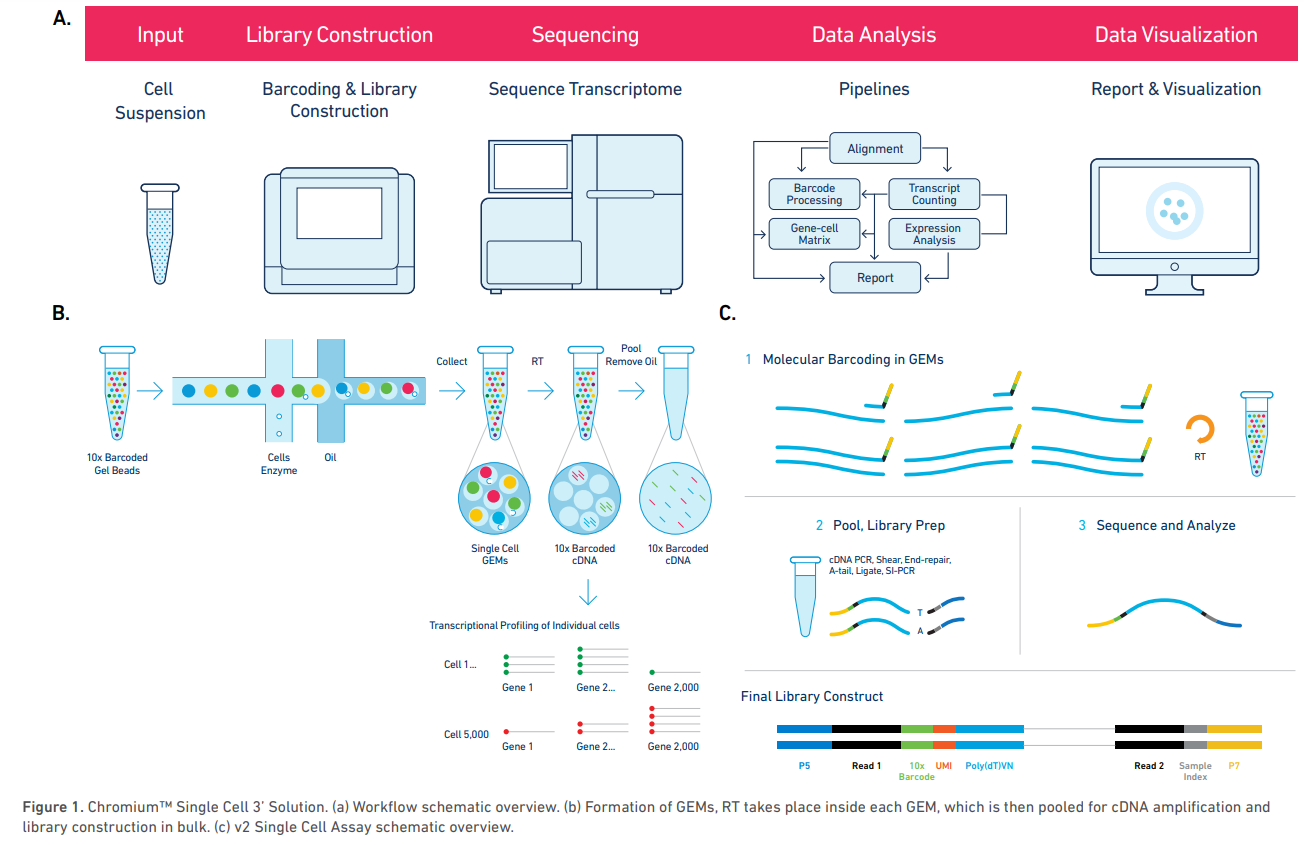

# **Dataset Overview: Human Organoids Study**

## **Data Description**
In this analysis, we will work with **human organoid** data obtained from the **GEO database**. The dataset provides transcriptomic information from **wild-type (WT) human organoids**, allowing us to study gene expression patterns and network interactions.

## **Dataset Details**
| **Attribute** | **Details** |
|--------------|------------|
| **Source Name** | Human organoids |
| **Organism** | *Homo sapiens* |
| **Characteristics** | Tissue: Human organoids |
|  | Genotype: Wild-type (WT) |

This dataset is available from the **GEO repository** at the following link:  
[**GSM7732411 - GEO Accession**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7732411)

## **Objective of the Analysis**
- Explore **gene expression patterns** in human organoids.  
- Examine how QC affects clustering
-

This study provides insights into **wild-type human organoids**, which serve as a model for understanding **cellular differentiation, disease mechanisms, and therapeutic applications**.

# Dependencies

In [6]:
pip install --upgrade scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=bfcc5d61fae737c08b36ac534a94f8c41d08e3c7d13aac9a8892cf48196c5a3c
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [8]:
# Core scverse libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

In [7]:
# Locating you working directory
!pwd

/content


# Data Preprocessing

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="500" height="500">

This is the architecture of Anndata object, which is the core of `Scanpy`/`scverse` analysis of single-cell datasets.

# **Quick Notes on AnnData Format**

## **What is AnnData?**
AnnData (`anndata.AnnData`) is a data structure optimized for **single-cell omics** analysis, storing gene expression data along with metadata.

## **Main Components**
- **`.X`** → The main data matrix (sparse or dense), usually UMI counts or normalized expression.
- **`.obs`** → Cell metadata (e.g., `cell_type`, `batch`, `total_counts`).
- **`.var`** → Gene metadata (e.g., `gene_symbols`, `highly_variable`).
- **`.obsm`** → Embeddings (e.g., `X_pca`, `X_umap`).
- **`.uns`** → Unstructured data (e.g., clustering results, visualization settings).
- **`.layers`** → Alternative data representations (e.g., `raw`, `log1p`, `scaled`).

## **Example: Loading and Inspecting AnnData**
```python
import scanpy as sc

adata = sc.read_h5ad("dataset.h5ad")  # Load an AnnData file
print(adata)  # Quick overview
print(adata.obs.head())  # Check cell metadata
print(adata.var.head())  # Check gene metadata


# **Essential Components for Assembling an AnnData Object in Scanpy**

## **1. Core Data Matrices**
- **`.X`** → The primary data matrix (usually UMI counts or normalized expression values).
- **`adata.layers["counts"]`** → Stores raw counts separately from normalized data.
- **`adata.raw`** → Preserves raw untransformed data before normalization or log transformation.

## **2. Gene and Cell Metadata**
- **`adata.var`** → Contains gene-level metadata (e.g., gene names, feature selection).
  - Example columns: `gene_ids`, `highly_variable`, `mt_gene`
- **`adata.obs`** → Contains cell-level metadata (e.g., sample ID, clustering labels).
  - Example columns: `cell_type`, `patient_id`, `n_genes_by_counts`, `percent_mito`

## **3. Quality Control Metrics**
- **`n_genes_by_counts`** → Number of detected genes per cell.
- **`total_counts`** → Total UMI counts per cell.
- **`pct_counts_mt`** → Percentage of mitochondrial reads (indicator of cell stress).

## **4. Dimensionality Reduction and Embeddings**
- **`adata.obsm["X_pca"]`** → Principal Component Analysis (PCA) embedding.
- **`adata.obsm["X_umap"]`** → Uniform Manifold Approximation and Projection (UMAP) embedding.
- **`adata.obsm["X_tsne"]`** → t-SNE embedding.

## **5. Clustering and Cell Annotations**
- **`adata.obs["leiden"]`** → Leiden clustering labels.
- **`adata.obs["louvain"]`** → Louvain clustering labels.
- **`adata.obs["cell_type"]`** → Manual or automated cell type annotations.

## **6. Graph-Based Representations (for Clustering)**
- **`adata.obsp["distances"]`** → KNN graph distance matrix.
- **`adata.obsp["connectivities"]`** → Graph connectivities used in clustering.

## **7. Differential Expression Results**
- **`adata.uns["rank_genes_groups"]`** → Stores results from differential expression analysis (e.g., Wilcoxon test).
- **`adata.uns["log1p"]`** → Information on log-transformed data.

## **8. Storing Additional Layers**
- **`adata.layers["log1p"]`** → Log-transformed expression values.
- **`adata.layers["normalized"]`** → Total-count normalized values.
- **`adata.layers["scaled"]`** → Z-score scaled data for visualization.

---

### **Loading Data into AnnData**
#### **From 10X Genomics**
```python
import scanpy as sc

adata = sc.read_10x_mtx(
    "path/to/filtered_feature_bc_matrix/",
    var_names="gene_symbols",
    cache=True
)


## Loading in Scanpy

In [ ]:
# Load data into Scanpy

In [ ]:
# import pandas as pd
# genes_path = "./organoids/genes.tsv.gz"  # Or features.tsv.gz
# genes = pd.read_csv(genes_path, sep='\t', header=None)
# print(genes.head())
# print(genes.shape)  # Check the number of columns

                 0            1
0  ENSG00000223972      DDX11L1
1  ENSG00000227232       WASH7P
2  ENSG00000278267    MIR6859-1
3  ENSG00000243485  MIR1302-2HG
4  ENSG00000284332    MIR1302-2
(58336, 2)


In [ ]:
# genes['feature_type'] = 'Gene Expression'
# genes.to_csv("./organoids/features.tsv.gz", sep='\t', index=False, header=False)

In [1]:
!pip install gdown

In [3]:
# We download the necessary files for assembling the single-cell object from Google Drive which are in typical 10x format post-Cell Ranger
!gdown --id 1cDTjLg7yn9ApH6YBClEz3cPNraFMVtWp -O organoids.tar.gz

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cDTjLg7yn9ApH6YBClEz3cPNraFMVtWp
To: /content/organoids.tar.gz
100% 6.77M/6.77M [00:00<00:00, 21.0MB/s]


In [4]:
# Decompressing
!tar -xzvf organoids.tar.gz

organoids/
organoids/features.tsv.gz
organoids/._barcodes.tsv.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
organoids/barcodes.tsv.gz
organoids/._genes.tsv.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
organoids/genes.tsv.gz
organoids/._matrix.mtx.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
organoids/mat

In [9]:
# Path to the folder containing the matrix, barcodes, and genes files
data_folder = "./organoids"

# Load the data
adata = sc.read_10x_mtx(
    data_folder,       # Path to the folder containing the files
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True         # Cache the result for faster reloading
)

# Inspect the loaded data
print(adata)

AnnData object with n_obs × n_vars = 6009 × 58336
    var: 'gene_ids', 'feature_types'


# Quality Control (QC)

## Importance of Quality Control in Single-Cell Analysis

## Introduction
Single-cell RNA sequencing (scRNA-seq) has revolutionized our ability to study cellular heterogeneity and transcriptional dynamics at an unprecedented resolution. However, the high sensitivity of this technique makes it particularly susceptible to technical noise and artifacts. Quality control (QC) is a critical step in single-cell analysis to ensure reliable and biologically meaningful results.

## Key Reasons for Quality Control

### 1. **Removal of Low-Quality Cells**
- Some cells may have low RNA content or be damaged during sample preparation, leading to incomplete transcriptomes.
- Cells with an unusually high percentage of mitochondrial reads indicate potential cell stress or apoptosis.
- Filtering out low-quality cells improves downstream clustering and differential expression analyses.

### 2. **Mitigating Technical Artifacts**
- Doublets (two or more cells captured in a single droplet) can artificially inflate gene expression levels.
- Ambient RNA contamination can introduce misleading transcripts into cell profiles.
- Normalization and batch correction techniques help reduce unwanted technical variation.

### 3. **Ensuring Accurate Cell-Type Identification**
- Cells with insufficient feature counts or high dropout rates can distort clustering and cell annotation.
- Proper QC ensures that the final dataset reflects true biological heterogeneity rather than sequencing artifacts.

### 4. **Enhancing Reproducibility and Comparability**
- Poor-quality data can lead to irreproducible results that fail validation in independent experiments.
- QC allows for standardization across datasets, improving comparability in large-scale studies or meta-analyses.

### 5. **Optimizing Computational Performance**
- Retaining only high-quality cells reduces computational costs and prevents downstream analyses from being overwhelmed by noisy data.
- Streamlining datasets ensures more accurate and efficient clustering, trajectory inference, and gene regulatory network modeling.

## Common Quality Control Metrics

| Metric               | Description                                       | Common Thresholds |
|----------------------|-------------------------------------------------|-------------------|
| **Library Size**     | Total number of detected reads per cell         | Remove extreme outliers |
| **Feature Count**    | Number of unique genes detected per cell       | Filter cells with too few genes (< 500) |
| **Mitochondrial Content** | Percentage of mitochondrial reads          | Typically < 10% |
| **Doublet Score**    | Predicted probability of a cell being a doublet | Remove high-score doublets |
| **UMI Count**        | Number of unique molecular identifiers per cell | Normalize across cells |

## Conclusion
Quality control is an indispensable step in single-cell analysis to ensure that data reflects true biological variation rather than technical noise. Implementing stringent QC procedures improves the accuracy, reproducibility, and interpretability of single-cell studies, ultimately leading to more robust biological insights.

---

### Further Reading
- Luecken & Theis, 2019. *Current best practices in single-cell RNA-seq analysis*.
- Ilicic et al., 2016. *Classification of low-quality cells in single-cell RNA-seq data*.
- Andrews & Hemberg, 2018. *Identifying cell populations with scRNA-seq*.


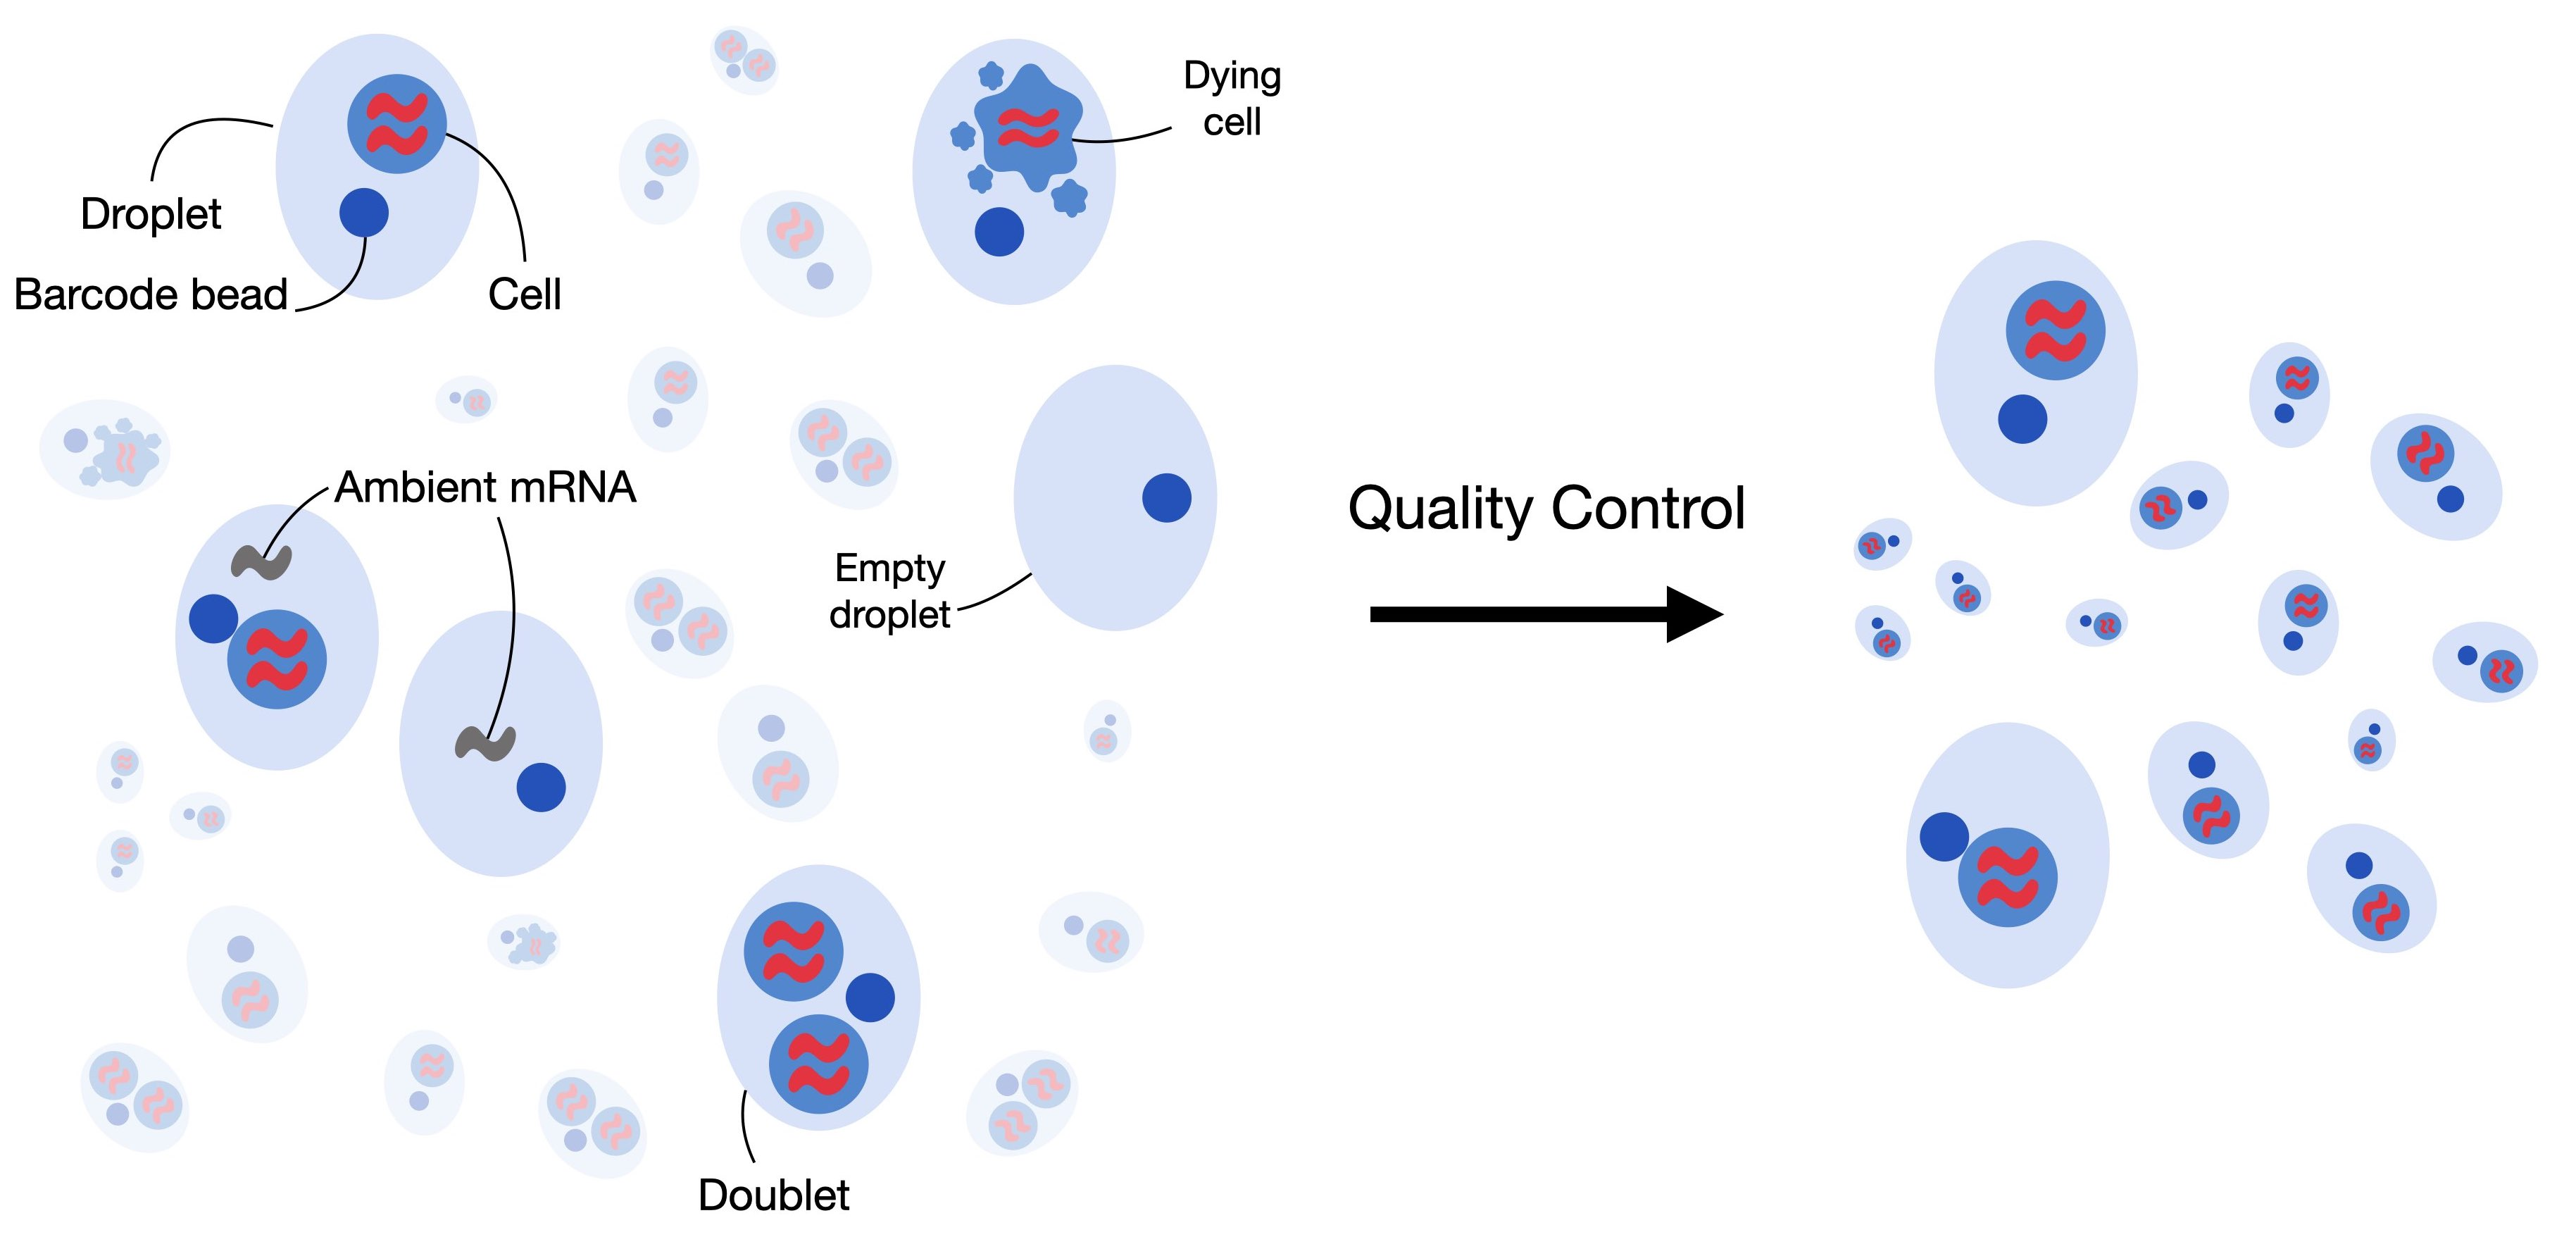

Single-cell RNA-seq datasets can contain low-quality cells, cell-free RNA and doublets. Quality control aims to remove and correct for those to obtain a high-quality dataset where each observation is an intact single cell

In [10]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

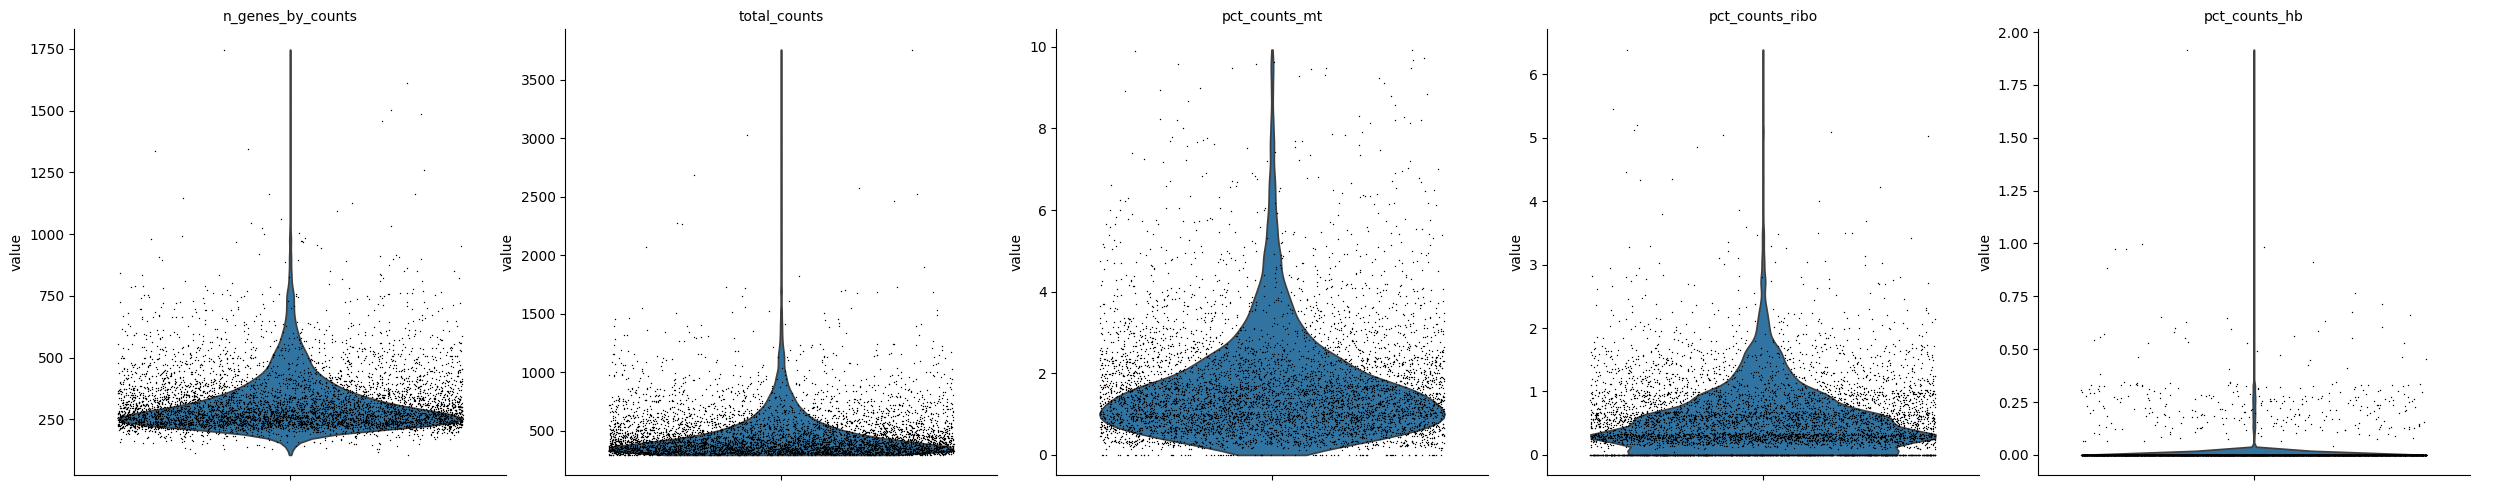

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

Some additional metrics to consider are ribosomal and HB gene content, here is why:

| **Feature**           | **Why QC?**                                                              | **Action**                                |
|----------------------|-------------------------------------------------------------------------|-------------------------------------------|
| **Ribosomal Genes (rRNA)** | High expression may indicate technical biases, poor poly-A selection, or stressed cells. | Remove cells with **`pct_ribo > 20%`**   |
| **Hemoglobin Genes (HB)**  | High expression in non-erythroid cells suggests RBC contamination or lysis inefficiency. | Remove cells with **`pct_hb > 5-10%`** (unless working with blood samples) |


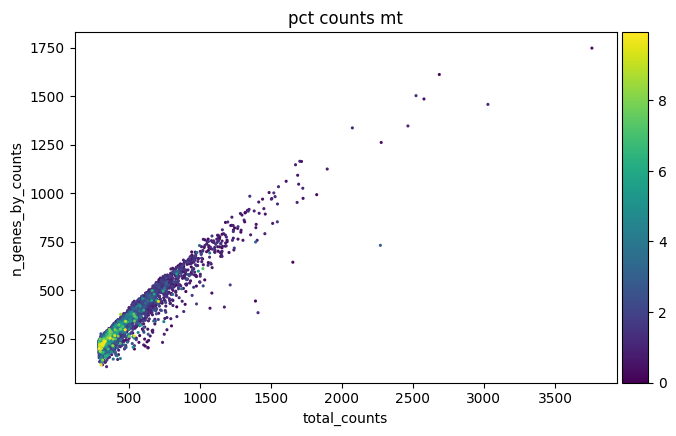

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

**What is this relationship telling us?**

The analyst usually decides filtering, but automated methods for QC are appearing on the horizon.

In [14]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

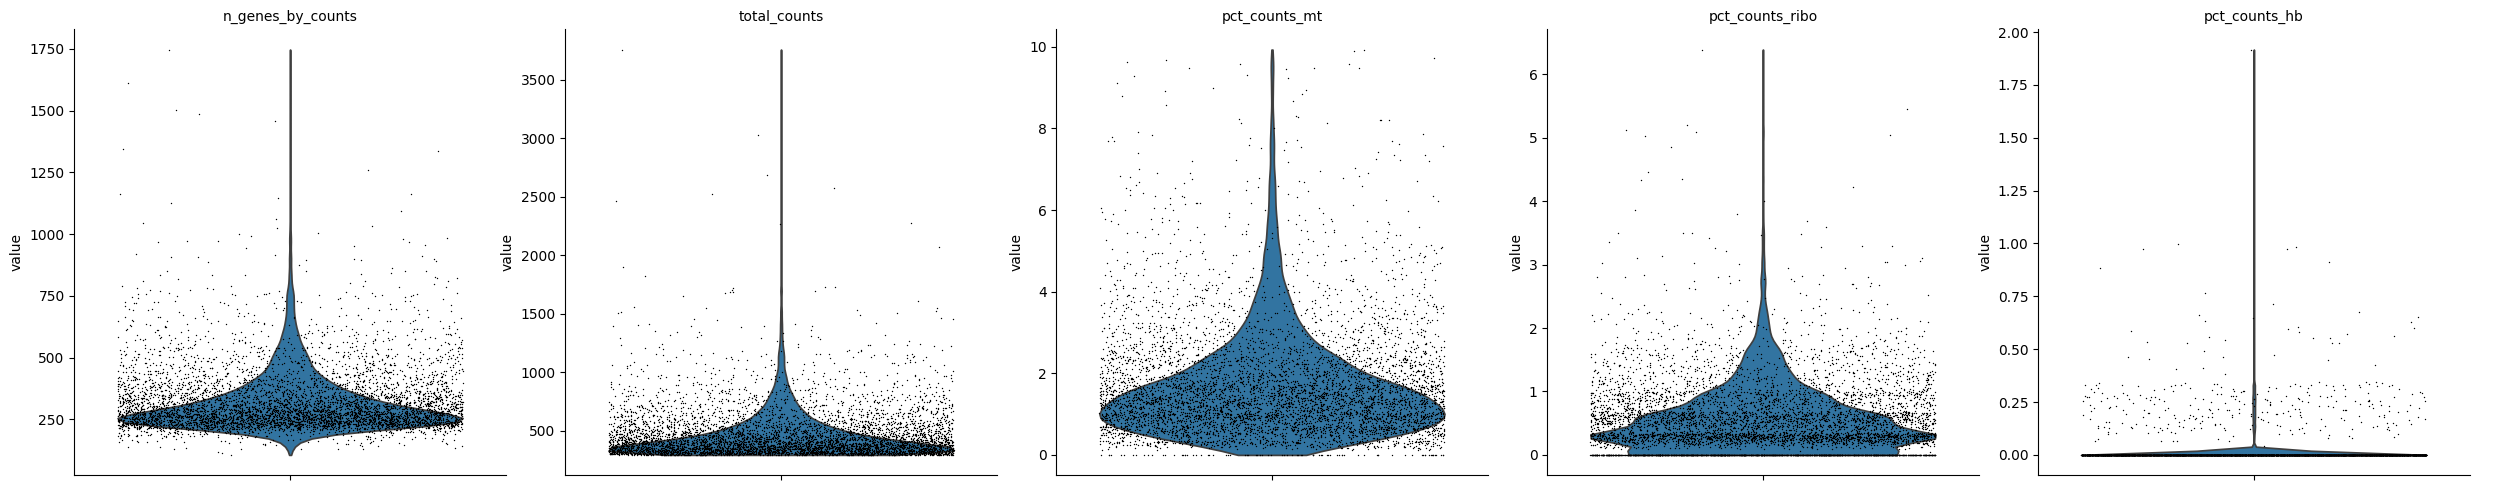

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

## Doublet detection

### **Why is Doublet Detection Important in Single-Cell RNA-Seq?**  

### **1. Prevents Artificial Cell States**  
- Doublets (two cells captured in one droplet) **mimic hybrid transcriptomes**, leading to false cell states.  

### **2. Improves Clustering Accuracy**  
- Doublets **distort clustering** by introducing mixed cell identities, affecting downstream analyses.  

### **3. Avoids Misleading Differential Expression (DE) Analysis**  
- Artificial gene expression profiles can **skew DE results**, leading to incorrect biological interpretations.  

### **4. Essential for High Cell Recovery Protocols**  
- Higher cell loading increases **doublet formation (~5-10% in standard 10x runs, higher in high-throughput methods)**.  

### **5. Doublet Detection Methods**  
- **Experimental**: Use **multiplet rate estimates** based on cell loading density.  
- **Computational**: Use tools like **Scrublet, DoubletFinder, scDblFinder** to identify and filter doublets.  


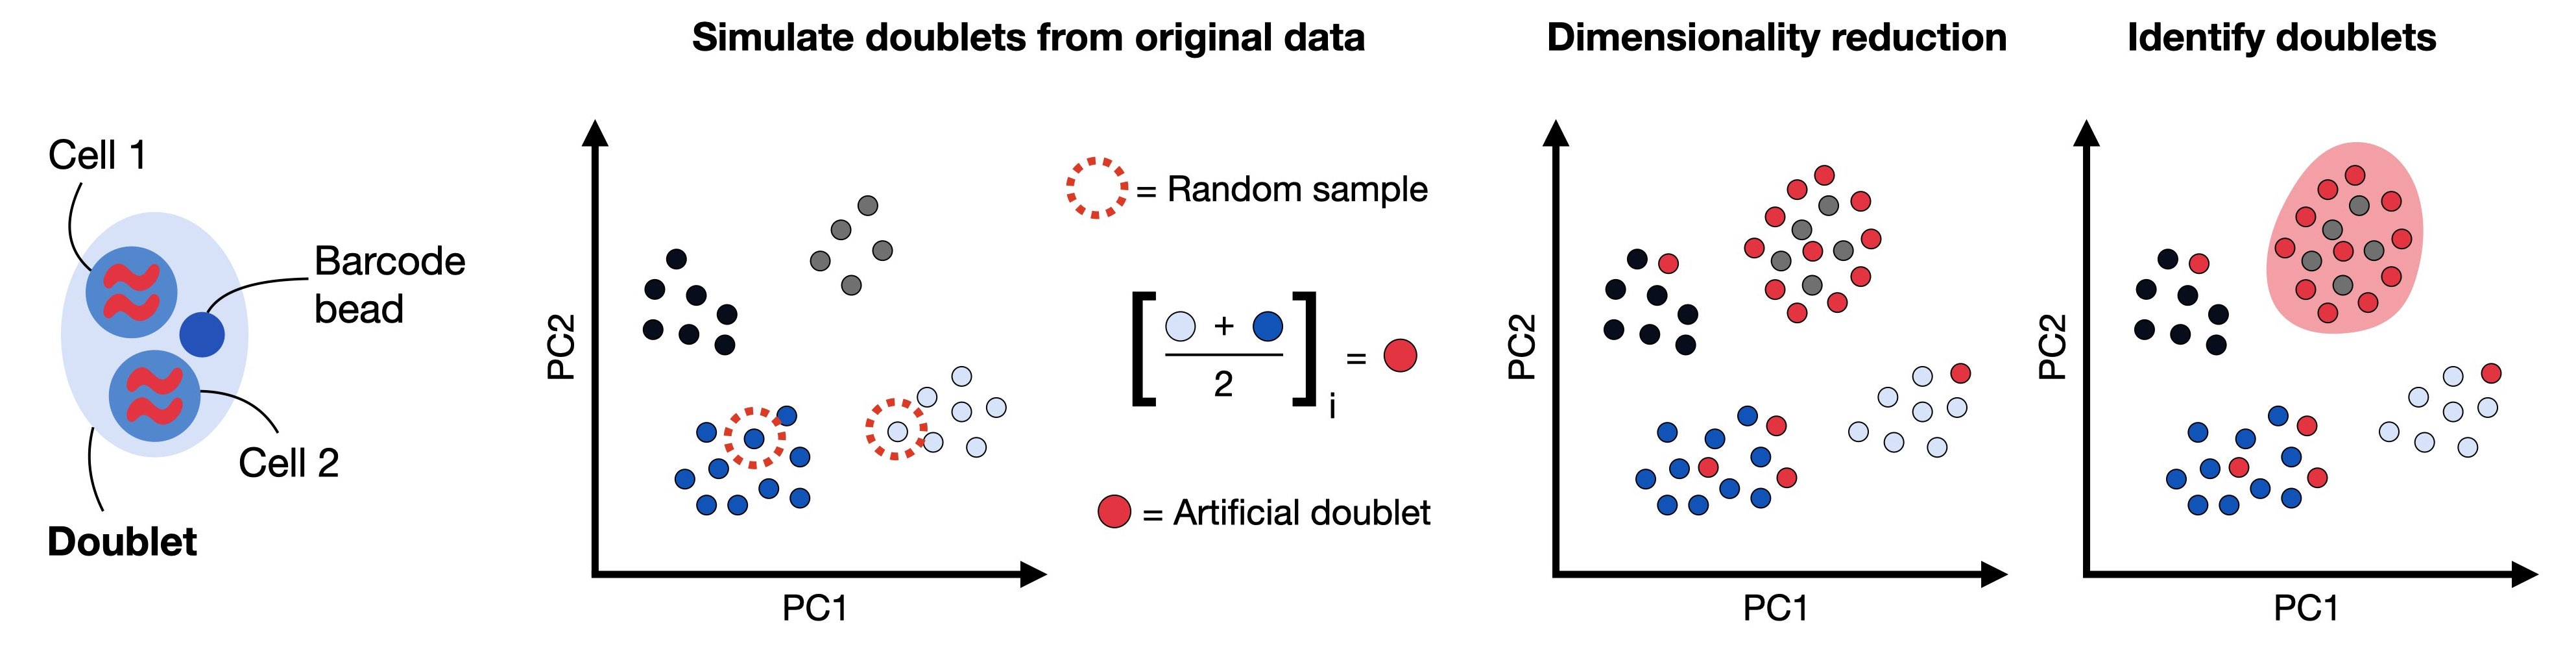

In [ ]:
# !pip install scikit-image

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 5.2 MB/s eta 0:00:00a 0:00:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
# sc.pp.scrublet(adata)

# Normalisation

In [19]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [20]:
adata_backup = adata

In [22]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Feature Selection

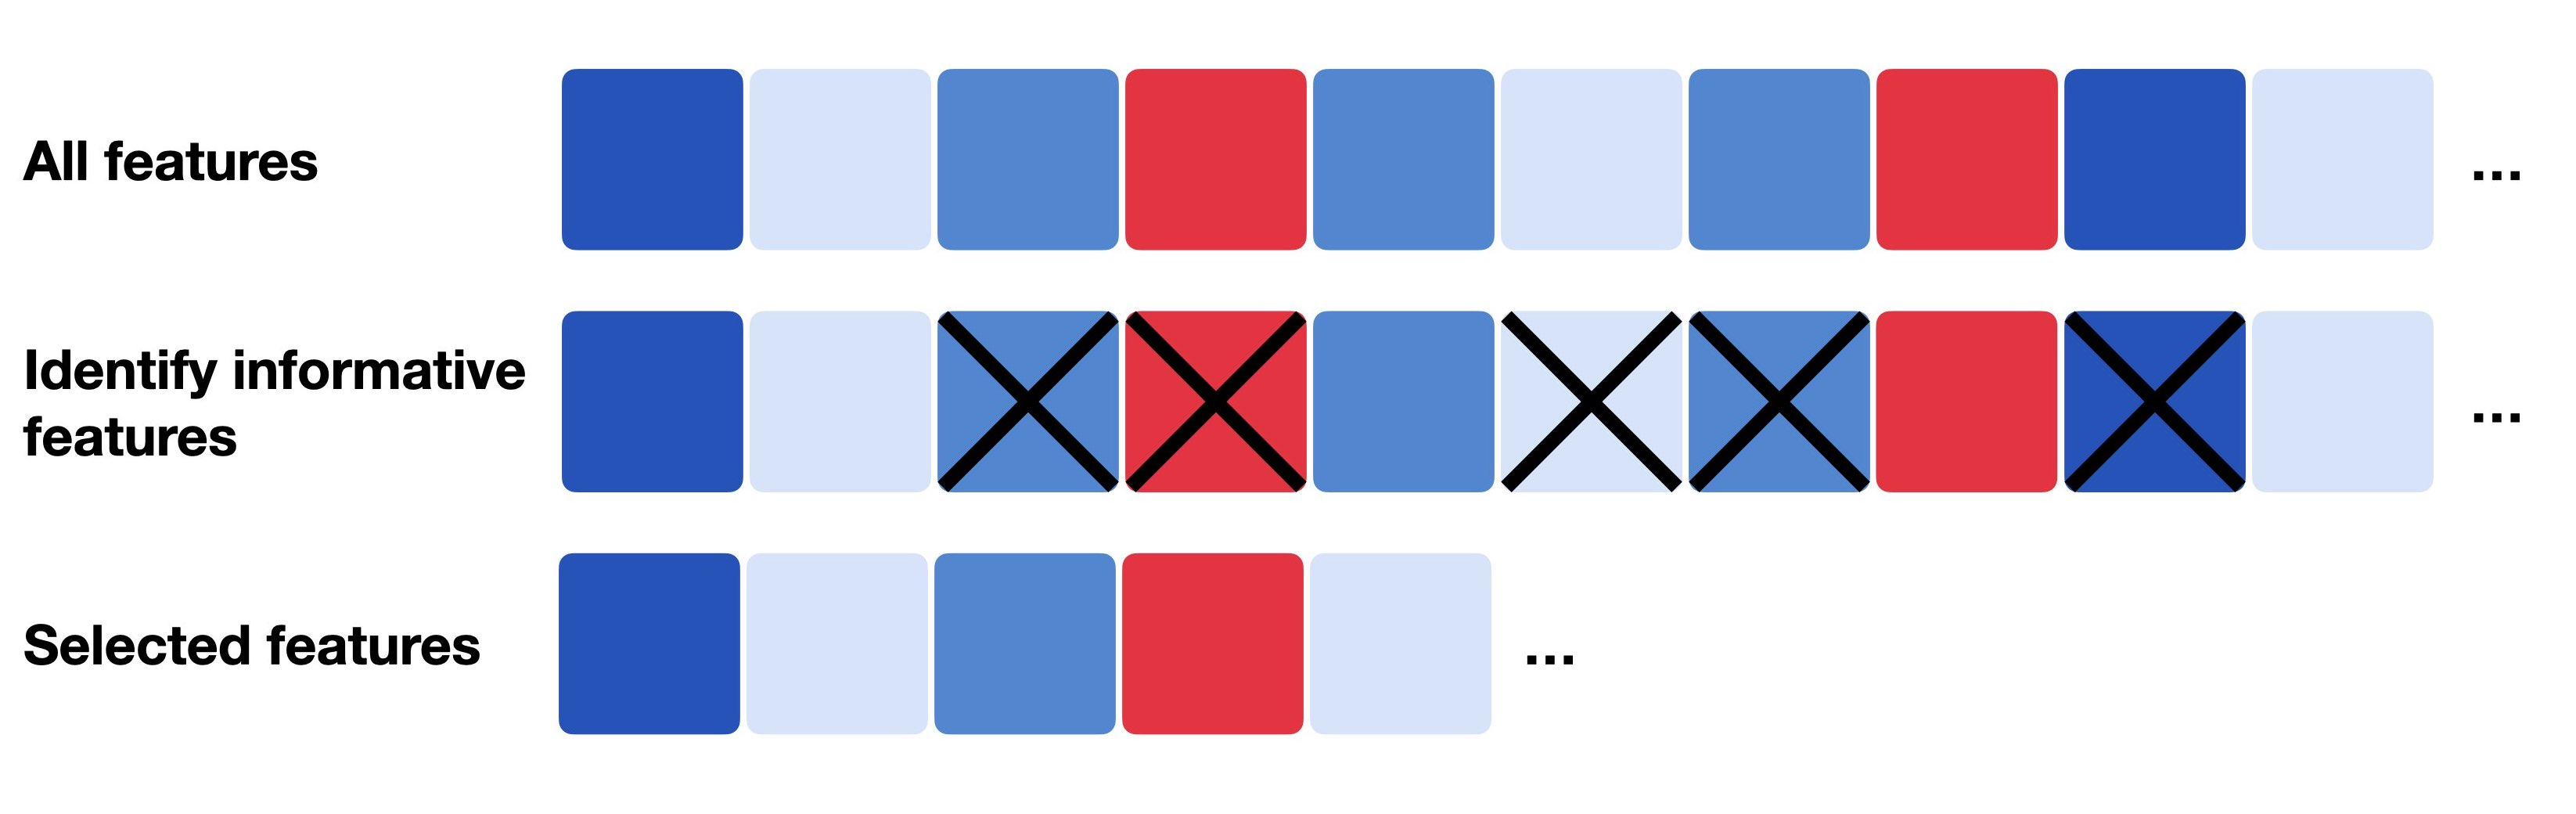

Feature selection generally describes the process of only selecting a subset of relevant features which can be the most informative, most variable or most deviant ones

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

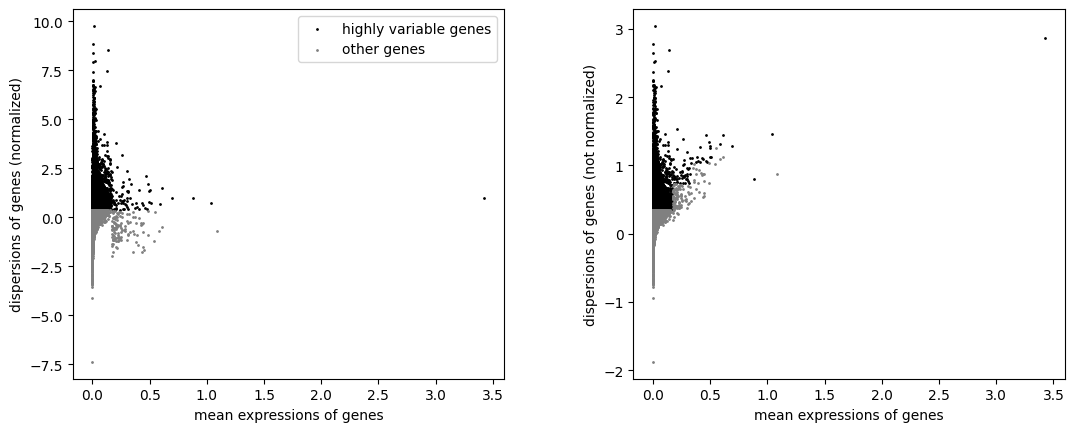

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
# List of genes to check
genes_of_interest = ["SIAH1", "SNCA"]

# Check if the `highly_variable` column exists
if 'highly_variable' in adata.var.columns:
    # Subset the DataFrame to the genes of interest
    genes_in_hvg = adata.var.loc[adata.var.index.isin(genes_of_interest) & adata.var['highly_variable']]

    # Print the result
    if not genes_in_hvg.empty:
        print("The following genes are in the HVGs:")
        print(genes_in_hvg.index.tolist())
    else:
        print("None of the genes of interest are in the HVGs.")
else:
    print("The HVG information is not available in `adata.var`.")


The following genes are in the HVGs:
['SNCA']


# Dimensionality Reduction

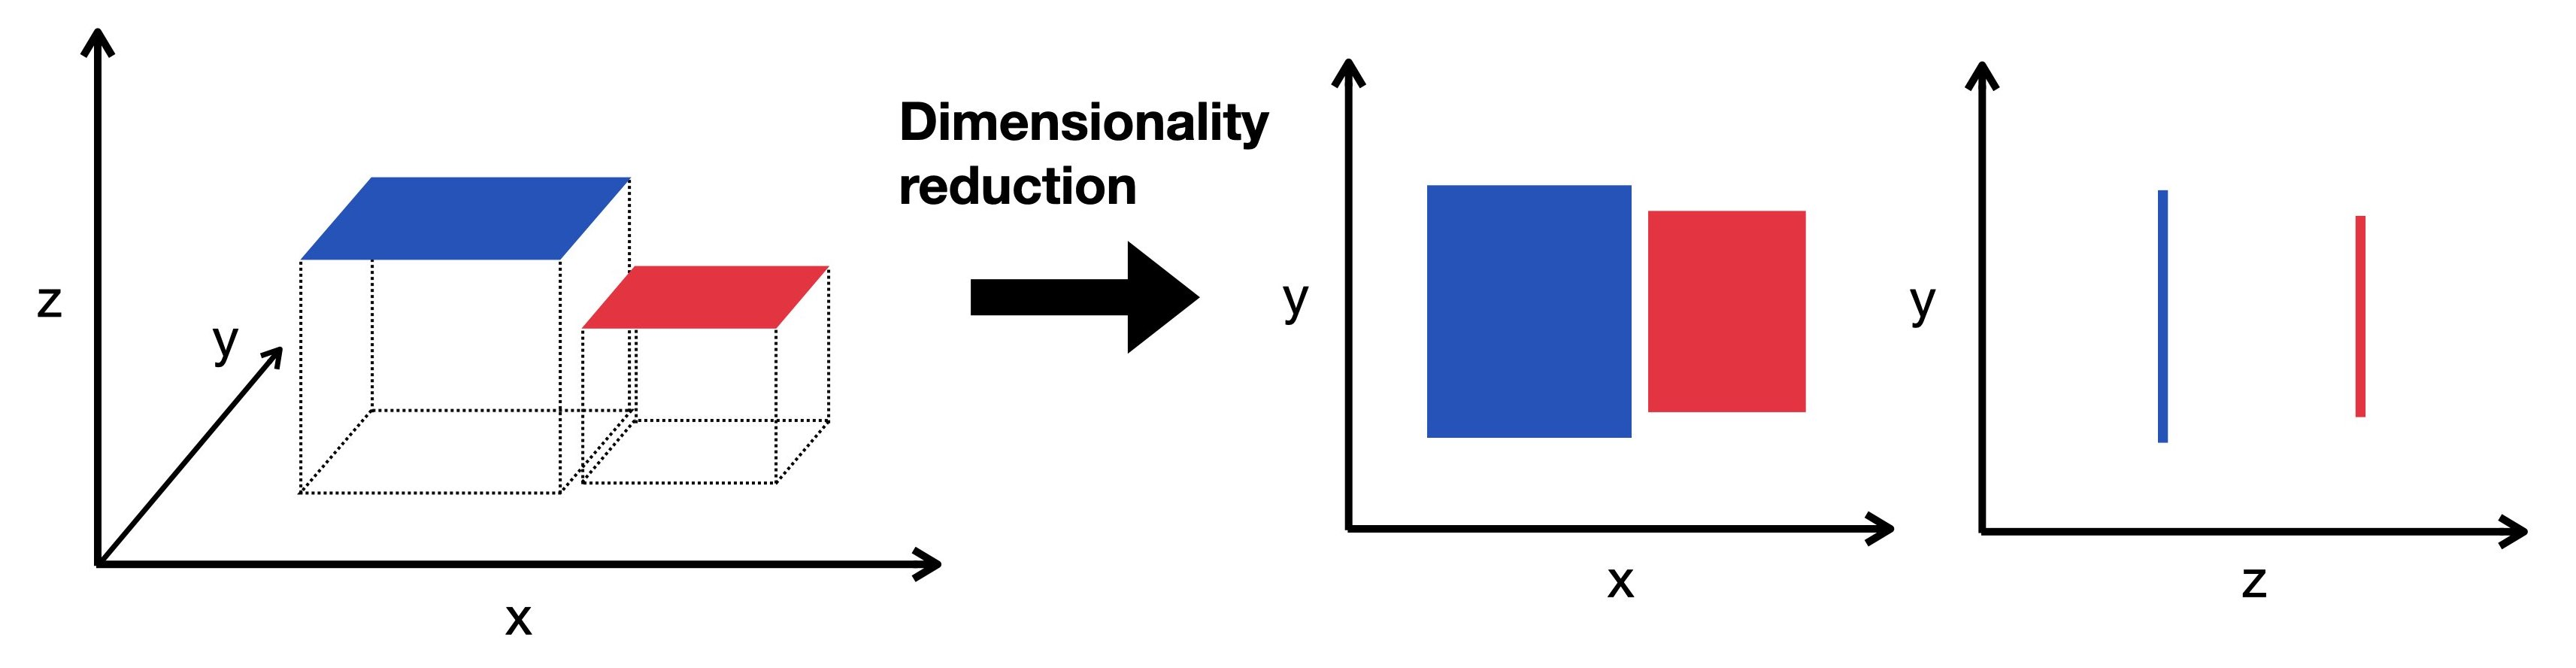

 Dimensionality reduction embeds the high-dimensional data into a lower dimensional space. The low-dimensional representation still captures the underlying structure of the data while having as few as possible dimensions. Here we visualize a three dimensional object projected into two dimensions.

In [26]:
sc.tl.pca(adata)

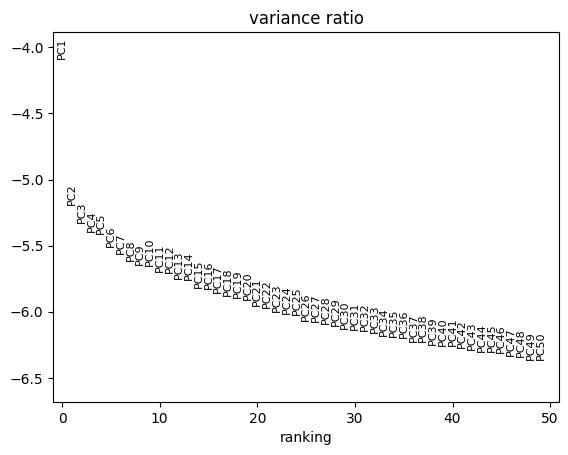

In [27]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

# Nearest neighbor graph constuction, clustering and visualization

In [28]:
sc.pp.neighbors(adata)

In [29]:
sc.tl.umap(adata)

In [38]:
!pip3 install igraph
!pip3 install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.1 MB/s eta 0:00:00


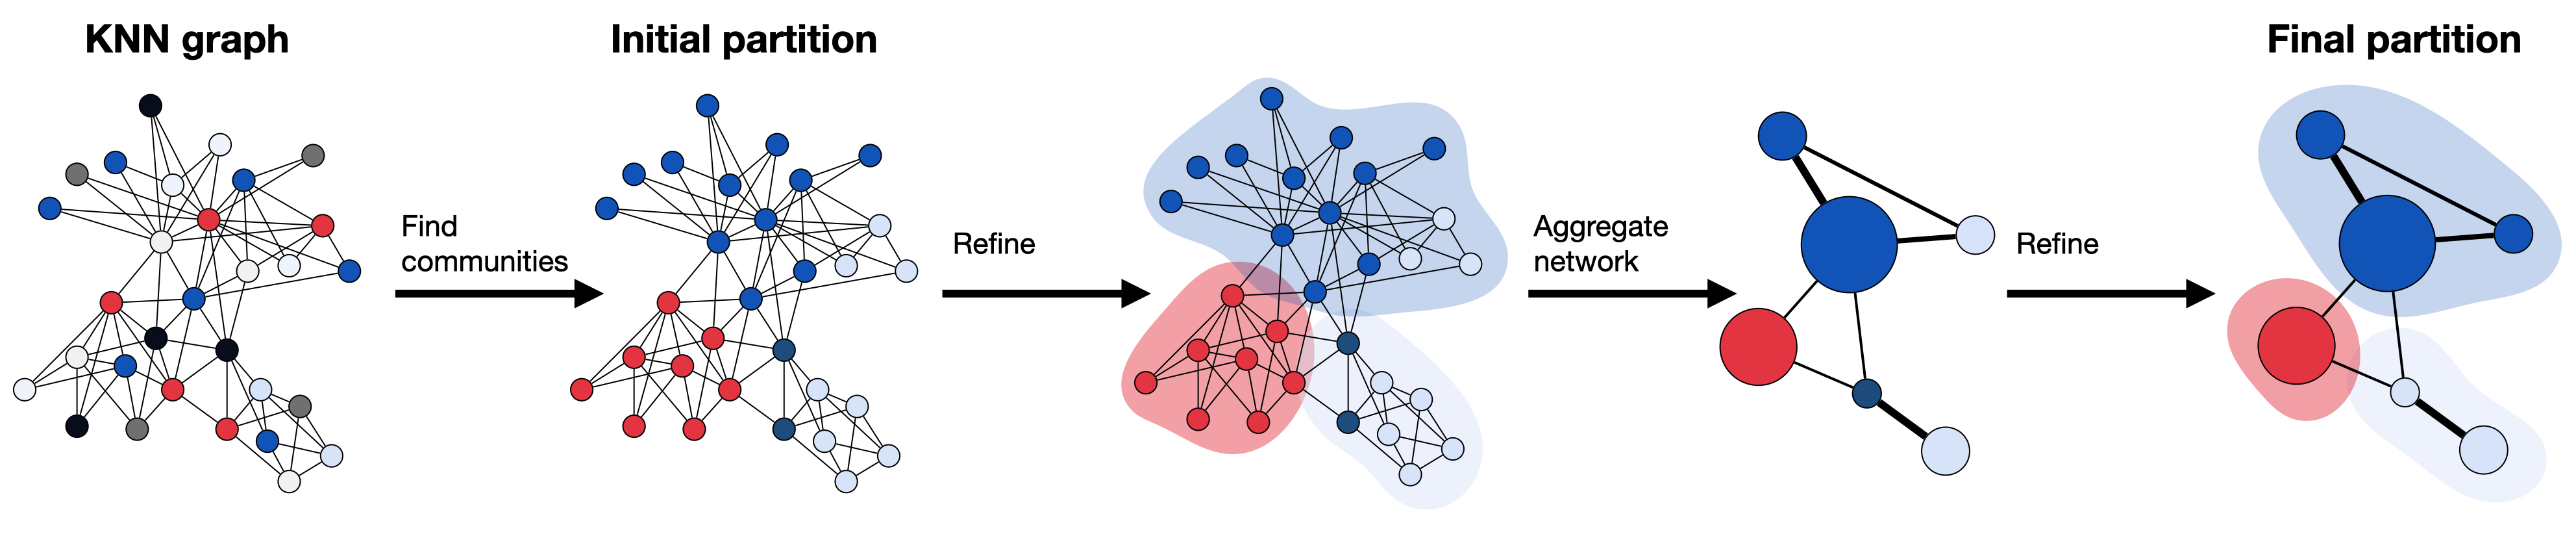

The Leiden algorithm computes a clustering on a KNN graph obtained from the PC reduced expression space. It starts with an initial partition where each node from its own community. Next, the algorithm moves single nodes from one community to another to find a partition, which is then refined. Based on a refined partition an aggregate network is generated, which is again refined until no further improvements can be obtained, and the final partition is reached

In [44]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

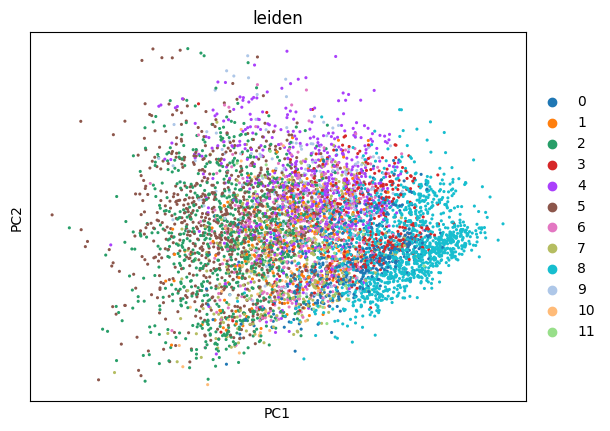

In [67]:
sc.pl.pca(adata, color = "leiden")

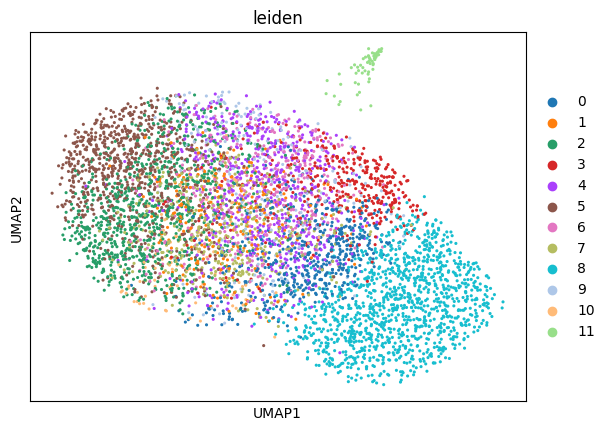

In [68]:
sc.pl.umap(adata, color=["leiden"])

❓**How can we change the number of clusters?**

❓**Why is PCA different than UMAP?**

❓**Where would you study trajectory pseudotime?**

# Marker genes

We are going to perform differential analysis in the concept of "one-vs-rest"
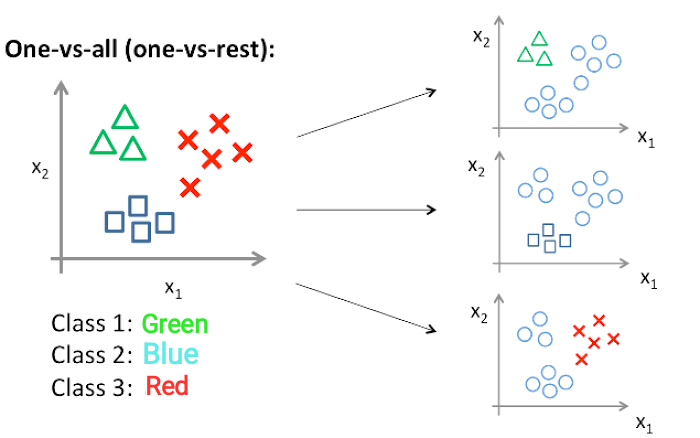

In [46]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

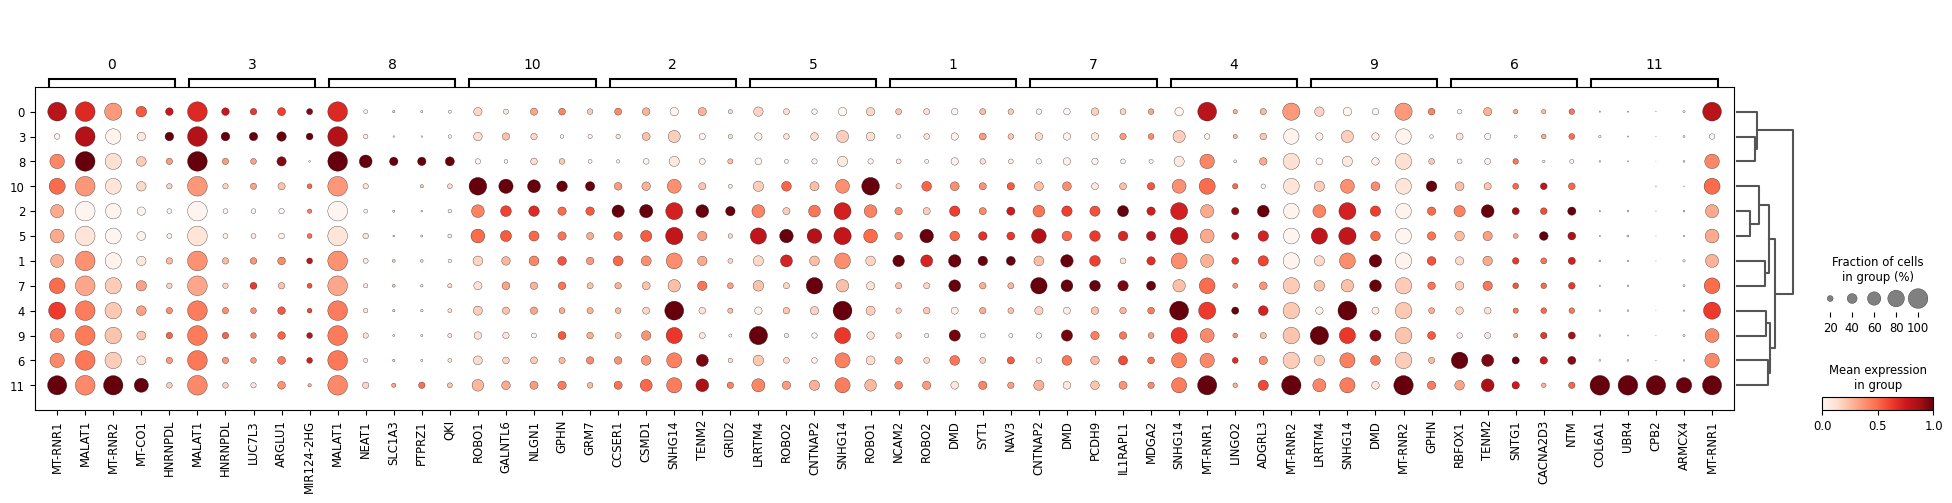

In [69]:
# Obtain cluster-specific differentially expressed genes
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [50]:
adata

AnnData object with n_obs × n_vars = 5978 × 19193
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [70]:
adata.var["highly_variable"]

WASH7P        False
AL627309.1    False
AL627309.6    False
FO538757.1    False
AP006222.1    False
              ...  
MT-ND6        False
MT-TE         False
MT-CYB        False
MT-TT         False
MT-TP         False
Name: highly_variable, Length: 19193, dtype: bool

In [66]:
hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()
print(f"Number of highly variable genes: {len(hvg_genes)}")
print(hvg_genes[:10])  # Print first 10 HVGshvg = adata.var.index[adata.var["highly_variable"]].tolist()  # Boolean mask,

Number of highly variable genes: 5000
['LINC01128', 'HES4', 'AL390719.1', 'DVL1', 'MXRA8', 'AL391244.3', 'ANKRD65', 'VWA1', 'ATAD3B', 'AL645728.2']


In [72]:
adata_v1 = adata

# SCTransform and Pearson Residuals

Alternative normalisation and scaling can be provided by [SCTransform method](https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html). Let's explore how it can affect downstream processing.

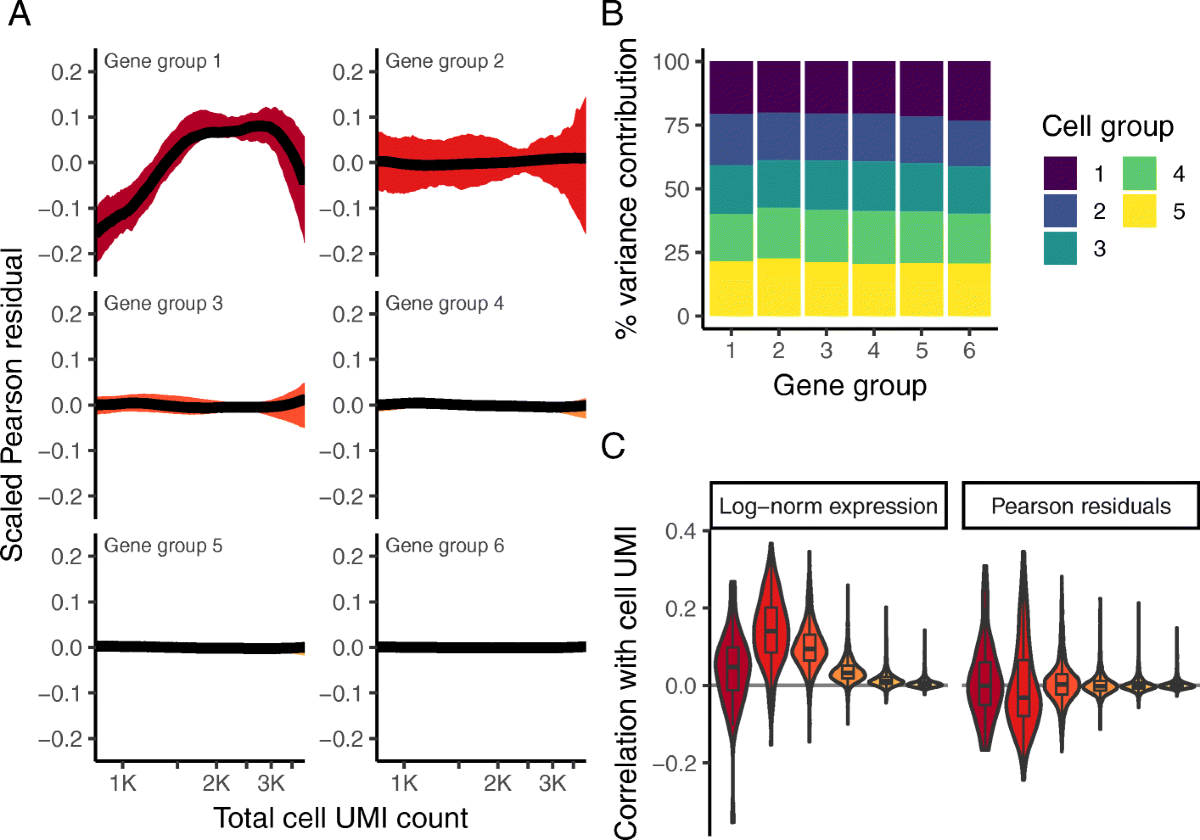

Pearson residuals transform raw UMI counts into a representation that achieves three key goals:

1. **Remove Technical Variation**  
   - Accounts for differences in total UMI counts across cells, reducing sequencing depth bias.  

2. **Stabilize the Mean-Variance Relationship**  
   - Ensures that both low and high-expression genes contribute meaningfully to downstream analyses.  

3. **Enhance Differential Expression Signal**  
   - Housekeeping genes (homogeneously expressed) have **low variance**, while marker genes (differentially expressed) have **high variance**.  

Thus, **computing Pearson residuals replaces the need for explicit sequencing-depth normalization and log-transformation** for variance stabilization.  

**Comparison to Seurat’s SCTransform**  
The analytic Pearson residuals used here are **conceptually similar** to Seurat’s **SCTransform model** (Hafemeister & Satija, 2019), but employ a **simplified model** that allows for an **analytic solution**.  

For more details, refer to **Lause et al. (2021)**.

In [110]:
adata = adata_backup

In [ ]:
# import scanpy as sc

# # Define cell cycle gene lists from Tirosh et al. (2016)
# s_genes = [
#     "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6",
#     "CDCA7", "DTL", "PRIM1", "UHRF1", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1",
#     "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51",
#     "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2",
#     "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"
# ]

# g2m_genes = [
#     "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
#     "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A",
#     "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANLN",
#     "LBR", "CENPE", "CTCF", "G2E3", "GAS2L3", "NCAPG", "HJURP", "ESCO2",
#     "SGOL2", "PIMREG", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF20B",
#     "TFAP2C", "UBE2T"
# ]

# # Make sure genes are present in your dataset
# s_genes = [gene for gene in s_genes if gene in adata.var_names]
# g2m_genes = [gene for gene in g2m_genes if gene in adata.var_names]

# # Compute cell cycle scores
# sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# # Check the computed cell cycle scores
# print(adata.obs[['S_score', 'G2M_score', 'phase']].head())

                              S_score  G2M_score phase
AACACACAGAACGCTAGTACTATCGCC -0.008772  -0.002770    G1
AACACACAGAACGCTAGTCCATCCTAA -0.005848  -0.006925    G1
AACACACAGAACGTCCAACCATCCTAA -0.013158  -0.016620    G1
AACACACAGAACGTCCAACTCTGCTTA -0.004386  -0.008310    G1
AACACACAGAACGTCCAACTGCGTAGT -0.019006   0.009695   G2M


In [111]:
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

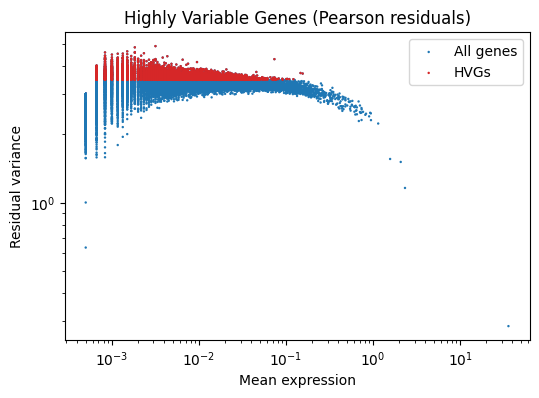

In [112]:
# Compute highly variable genes using Pearson residuals
for adata in [adata]:
    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=5000
    )

# Extract data
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Log scales & labels
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson residuals)")
plt.legend()
plt.show()

In [113]:
import scanpy as sc
import numpy as np

# Store raw counts before normalization
adata.layers["raw"] = adata.X.copy()

# Apply total-count normalization and square-root transform
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])

# Print confirmation
print("Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).")

Layers added: 'raw' (original counts), 'sqrt_norm' (sqrt-transformed normalized counts).


In [114]:
try:
    # Apply Pearson residual normalization
    sc.experimental.pp.normalize_pearson_residuals(adata)

    # Check for NaN values
    if np.isnan(adata.X).sum() > 0:
        raise ValueError("NaN values detected after Pearson residual normalization.")

except (RuntimeWarning, ValueError, FloatingPointError) as e:
    print(f"Warning: {e} - Applying gene filtering to handle zero-count genes.")

    # Remove genes with zero counts before retrying normalization
    sc.pp.filter_genes(adata, min_counts=1)

    # Retry normalization
    sc.experimental.pp.normalize_pearson_residuals(adata)

    # Ensure no NaN values exist in the final result
    adata.X = np.nan_to_num(adata.X)

# Store the transformed data in a new layer
adata.layers["pearson_residuals"] = adata.X.copy()

print("Pearson residual normalization completed successfully!")

Pearson residual normalization completed successfully!


In [115]:
# Use Pearson residuals as the main data matrix for downstream analysis
adata.X = adata.layers["pearson_residuals"].copy()

In [ ]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

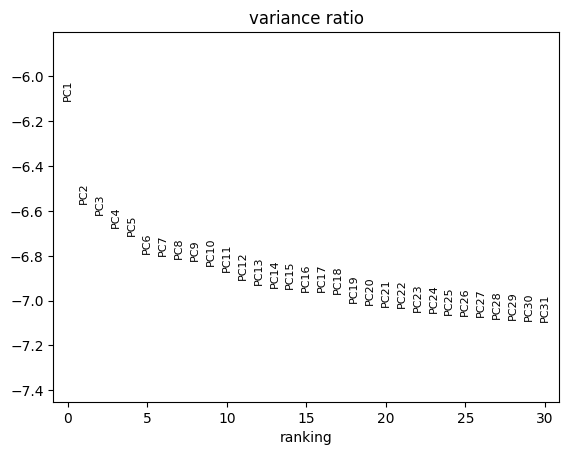

In [79]:
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [116]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [117]:
sc.tl.umap(adata)

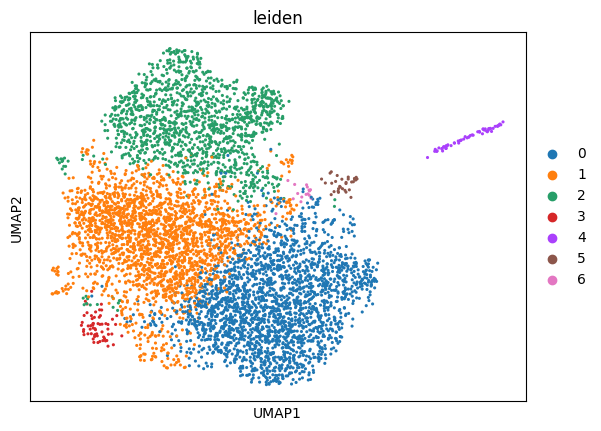

In [118]:
sc.tl.leiden(adata, resolution=0.25)  # Adjust resolution for granularity
sc.pl.umap(adata, color="leiden")  # Visualize clusters

In [103]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

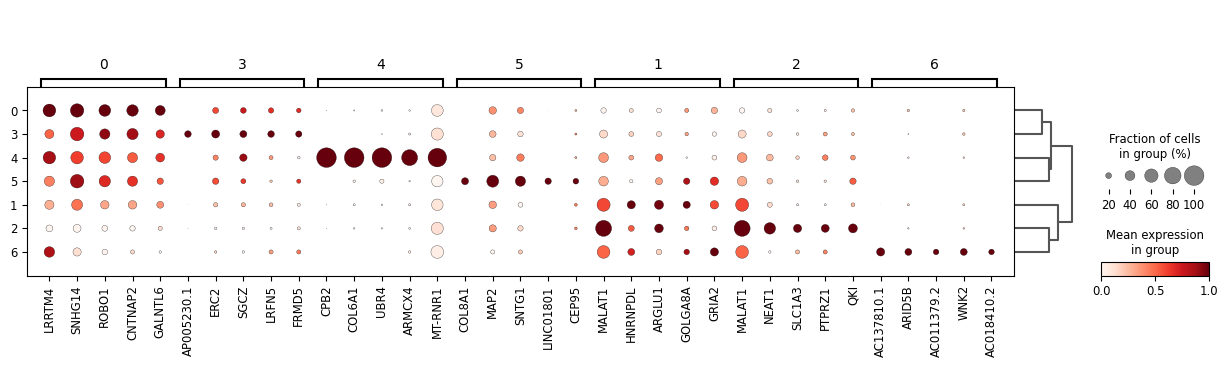

In [104]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

In [95]:
hvg_genes_sct = adata.var.index[adata.var["highly_variable"]].tolist()
print(f"Number of highly variable genes: {len(hvg_genes_sct)}")
print(hvg_genes_sct[:10])  # Print first 10 HVGshvg = adata.var.index[adata.var["highly_variable"]].tolist()  # Boolean mask,

Number of highly variable genes: 5000
['AL645608.7', 'KLHL17', 'AL645608.8', 'HES4', 'AL390719.1', 'MXRA8', 'AL391244.3', 'ANKRD65', 'VWA1', 'AL645728.2']


In [96]:
common_hvg = list(set(hvg_genes_sct) & set(hvg_genes))
print(f"Number of common HVGs: {len(common_hvg)}")
print(common_hvg[:10])  # Show first 10 common genes

Number of common HVGs: 3773
['CACNG4', 'LAMTOR4', 'VTI1A', 'MECOM', 'TCF12', 'SLC44A5', 'AC010267.1', 'CLIC4', 'AC135050.7', 'NOL4']


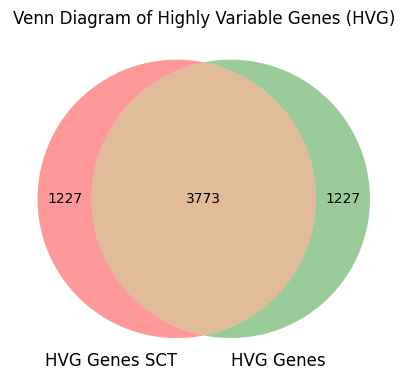

In [97]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Convert lists to sets
set_sct = set(hvg_genes_sct)
set_hvg = set(hvg_genes)

# Create Venn diagram
plt.figure(figsize=(5, 5))
venn2([set_sct, set_hvg], set_labels=("HVG Genes SCT", "HVG Genes"))

# Title
plt.title("Venn Diagram of Highly Variable Genes (HVG)")

# Show plot
plt.show()

# Comparing standard pipeline vs Pearson Residuals

In [98]:
# # List of gene markers for midbrain dopaminergic neurons in scRNA-seq analysis
# gene_markers = [
#     "TH",        # Tyrosine Hydroxylase: key enzyme in dopamine synthesis
#     "DDC",       # Aromatic L-Amino Acid Decarboxylase (AADC): converts L-DOPA to dopamine
#     "SLC18A2",   # VMAT2: packages dopamine into synaptic vesicles
#     #"SLC6A3",    # DAT: dopamine transporter for reuptake of dopamine
#     "NR4A2",     # NURR1: nuclear receptor essential for mDA neuron differentiation
#     #"PITX3",     # Pituitary homeobox 3: important for mDA neuron maturation and survival
#     #"LMX1A",     # LIM homeobox transcription factor 1 alpha: specifies mDA lineage
#     "LMX1B",     # LIM homeobox transcription factor 1 beta: involved in mDA neuron development
#     #"FOXA2",     # Forkhead box A2: indicates ventral midbrain (floor plate) identity
#     "EN1",       # Engrailed 1: midbrain marker involved in mDA development
#     "EN2",       # Engrailed 2: midbrain marker involved in mDA development
#     #"OTX2",      # Orthodenticle homeobox 2: involved in midbrain patterning
#     "KCNJ6",     # GIRK2: marker enriched in substantia nigra-like dopaminergic neurons
#     "CALB1",     # Calbindin: marker more common in ventral tegmental area (VTA)-like neurons
#     "GFAP", "RBFOX3", "NES"

# ]

# print(gene_markers)

['TH', 'DDC', 'SLC18A2', 'NR4A2', 'LMX1B', 'EN1', 'EN2', 'KCNJ6', 'CALB1', 'GFAP', 'RBFOX3', 'NES']


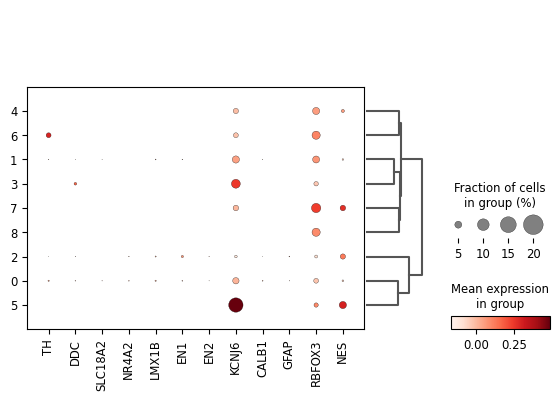

In [99]:
# sc.pl.dotplot(adata, gene_markers, "leiden", dendrogram=True)

## 1. Visualizing Raw vs. Normalized Expression

## Raw Counts

- The raw counts often exhibit large variability, with some genes having very high expression levels compared to others.
- This variability is visible in the violin plots, where some genes have broader distributions with higher medians.

## Square-root Normalization

- Applying the square root transformation reduces the influence of large outliers and compresses the dynamic range of the data.
- As a result, the distributions across genes become more similar, and the mean values appear closer together.
- This transformation preserves the relative differences between low- and high-expression values but makes the data less skewed.


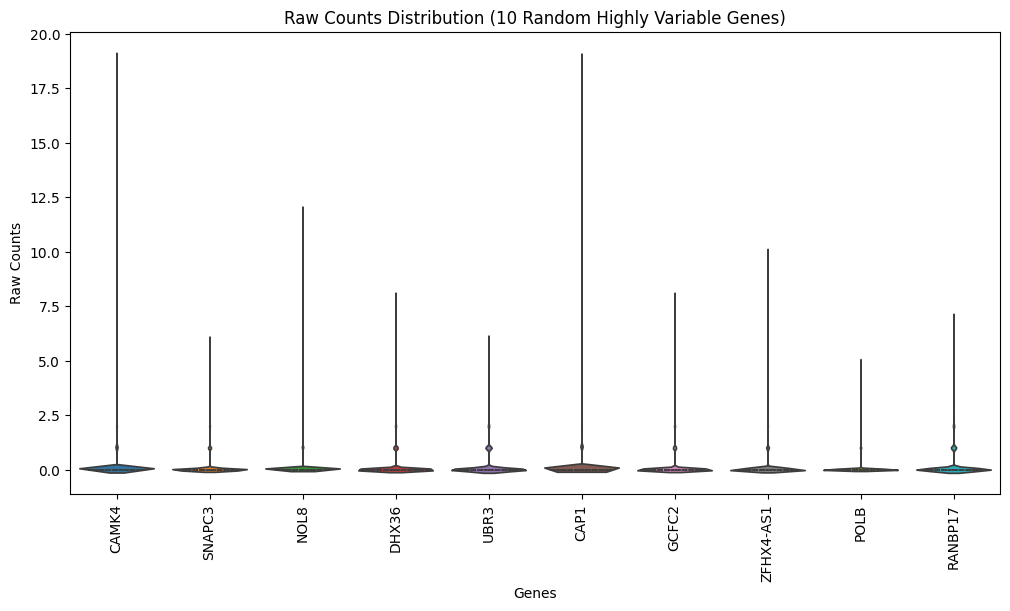

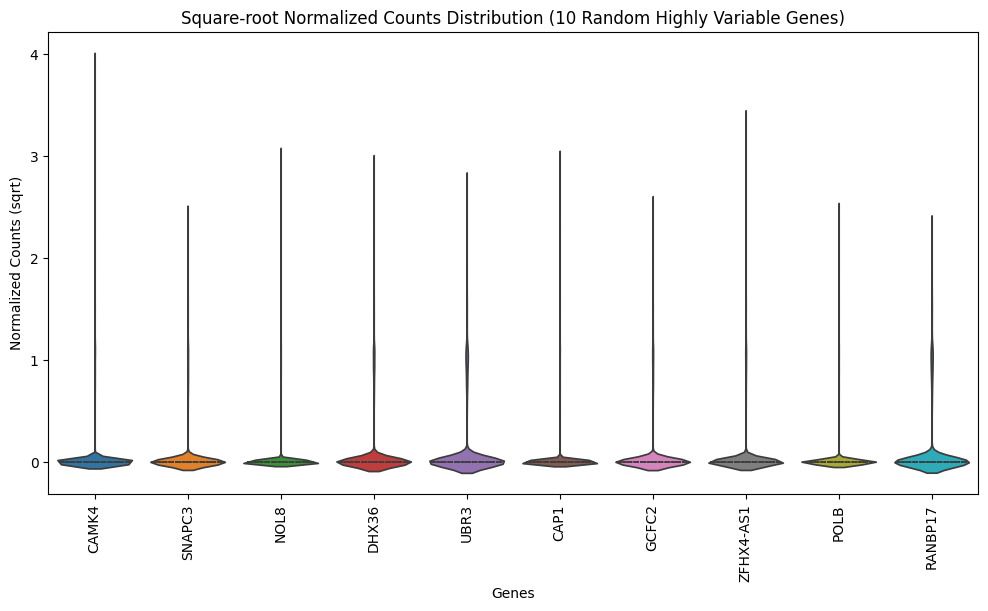

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Ensure HVG exists
if "highly_variable" in adata.var.columns:
    hvg_genes = adata.var.index[adata.var["highly_variable"]].tolist()
else:
    hvg_genes = adata.var_names.tolist()

# Select 10 random highly variable genes
random_genes = np.random.choice(hvg_genes, 10, replace=False)

# Convert sparse matrix to dense and create DataFrame
raw_counts = pd.DataFrame(adata[:, random_genes].layers["raw"].toarray(), columns=random_genes)

# Plot raw counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts = pd.DataFrame(adata[:, random_genes].layers["sqrt_norm"].toarray(), columns=random_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (10 Random Highly Variable Genes)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


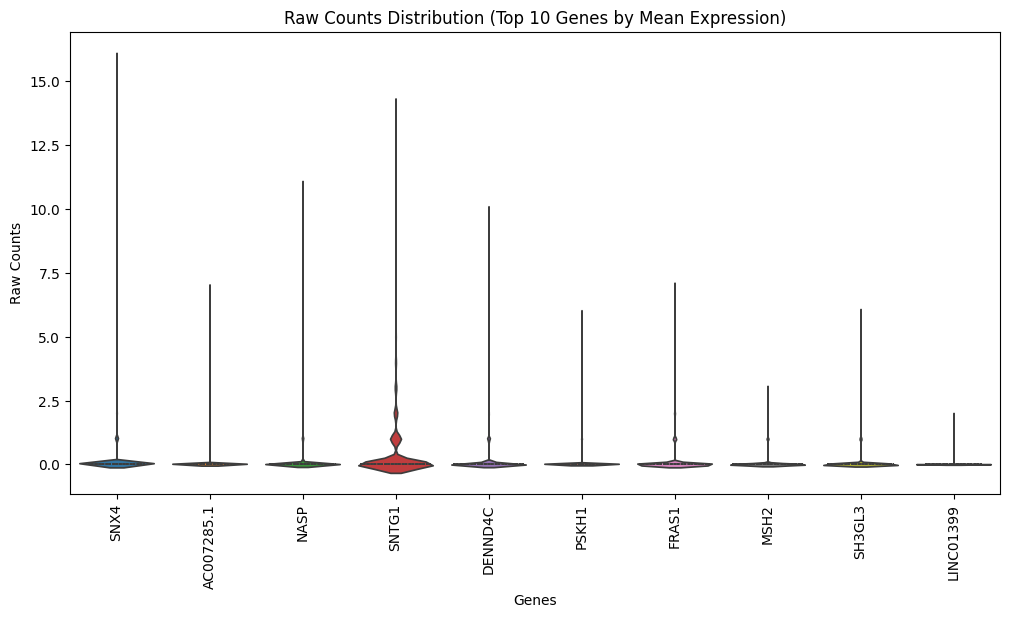

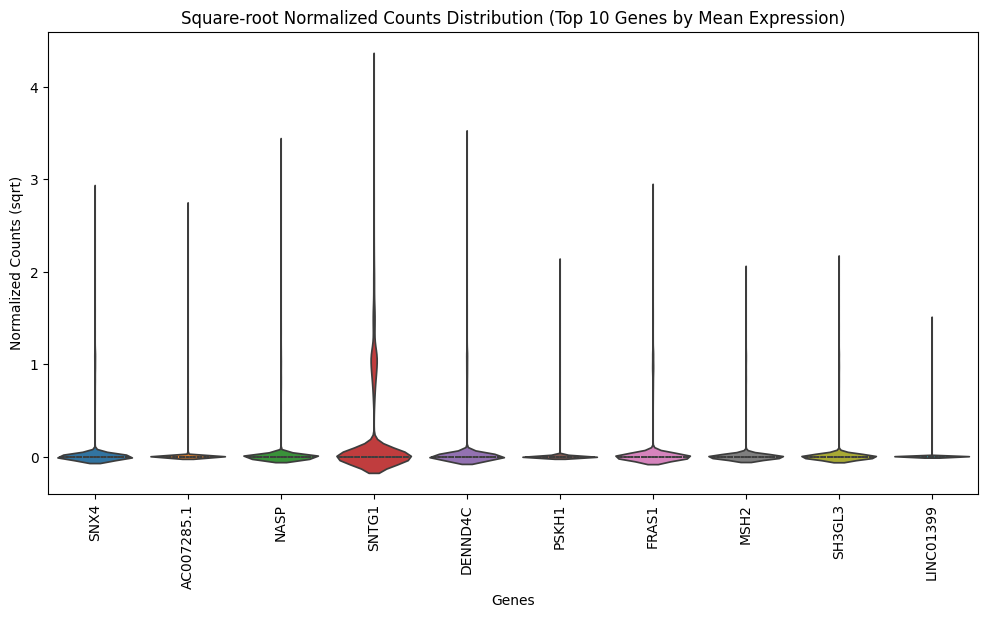

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check if mean expression exists in `adata.var`, otherwise compute it
if "vst.mean" in adata.var.columns:
    top_mean_genes = adata.var["vst.mean"].nlargest(10).index.tolist()
else:
    # Compute mean expression manually if not available
    mean_expression = adata.X.mean(axis=0).A1 if hasattr(adata.X, "A1") else adata.X.mean(axis=0)
    adata.var["mean_expression"] = mean_expression
    top_mean_genes = adata.var["mean_expression"].nlargest(10).index.tolist()

# Convert sparse matrix to dense and create DataFrame
raw_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["raw"].toarray(), columns=top_mean_genes)

# Plot raw counts for high mean expression genes
plt.figure(figsize=(12, 6))
sns.violinplot(data=raw_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Raw Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Raw Counts")
plt.show()

# Convert sparse matrix to dense for sqrt-normalized counts
sqrt_norm_counts_top = pd.DataFrame(adata[:, top_mean_genes].layers["sqrt_norm"].toarray(), columns=top_mean_genes)

# Plot sqrt-normalized counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=sqrt_norm_counts_top, inner="quartile")
plt.xticks(rotation=90)
plt.title("Square-root Normalized Counts Distribution (Top 10 Genes by Mean Expression)")
plt.xlabel("Genes")
plt.ylabel("Normalized Counts (sqrt)")
plt.show()


## 2. Mean-Variance Relationship Before & After Normalization

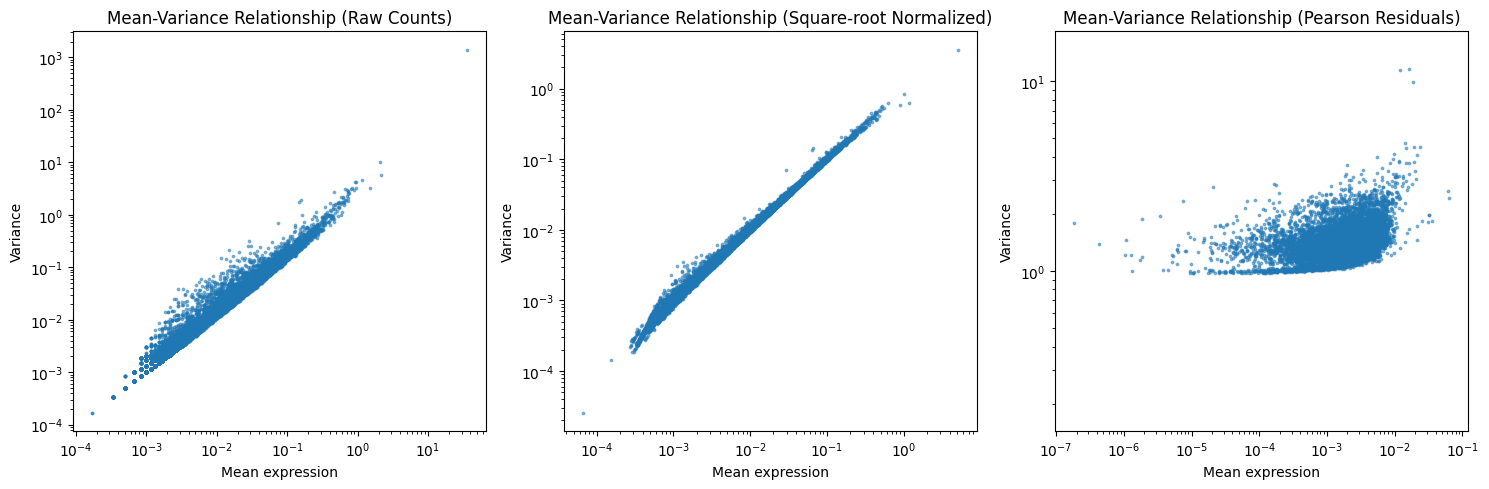

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 Convert sparse matrices to dense only if necessary
X_raw = adata.layers["raw"]
X_sqrt = adata.layers["sqrt_norm"]
X_pearson = adata.layers["pearson_residuals"]

if hasattr(X_raw, "toarray"):  # Check if it's sparse
    X_raw = X_raw.toarray()
if hasattr(X_sqrt, "toarray"):
    X_sqrt = X_sqrt.toarray()
if hasattr(X_pearson, "toarray"):
    X_pearson = X_pearson.toarray()

# 📌 Compute mean and variance
adata.var["mean_raw"] = np.mean(X_raw, axis=0)
adata.var["var_raw"] = np.var(X_raw, axis=0)

adata.var["mean_sqrt"] = np.mean(X_sqrt, axis=0)
adata.var["var_sqrt"] = np.var(X_sqrt, axis=0)

adata.var["mean_pearson"] = np.mean(X_pearson, axis=0)
adata.var["var_pearson"] = np.var(X_pearson, axis=0)

# 📌 Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, mean, var, title in zip(
    axes,
    ["mean_raw", "mean_sqrt", "mean_pearson"],
    ["var_raw", "var_sqrt", "var_pearson"],
    ["Raw Counts", "Square-root Normalized", "Pearson Residuals"]
):
    ax.scatter(adata.var[mean], adata.var[var], s=3, alpha=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Mean-Variance Relationship ({title})")
    ax.set_xlabel("Mean expression")
    ax.set_ylabel("Variance")

plt.tight_layout()
plt.show()

### **Mean-Variance Relationship Plots: Interpretation**

The plots compare the relationship between the **mean expression** and the **variance** of genes across three data transformations:

1. **Raw Counts**
2. **Square-root Normalized Counts**
3. **Pearson Residuals**

---

## **1️⃣ Raw Counts**
- **Trend:** Variance increases with the mean expression.
- **Key Observations:**
  - Highly expressed genes exhibit higher variability.
  - Lowly expressed genes show low variance but may be dominated by dropout effects.
- **Why it happens:** The raw count data is heavily affected by technical noise and biological variability, leading to strong **mean-variance dependency**.
- **Limitations:**
  - Not variance-stabilized.
  - Unsuitable for direct downstream analyses like clustering or differential expression.

---

## **2️⃣ Square-root Normalized Counts**
- **Trend:** The variance is reduced but still slightly dependent on the mean.
- **Key Observations:**
  - Square-root transformation compresses highly variable genes, making their variability less extreme.
  - Low-expression genes remain largely unaffected.
- **Why it happens:** Square-root normalization adjusts the scale of the data, reducing the impact of high expression values but does not fully remove systematic variance trends.
- **Strengths:**
  - Improves variance stabilization.
  - Useful for moderate adjustments.
- **Limitations:**
  - Still retains some mean-variance dependency, which may bias downstream results.

---

## **3️⃣ Pearson Residuals**
- **Trend:** Variance is independent of the mean, centered around **variance = 1**.
- **Key Observations:**
  - Most genes have residual variance ≈ 1, which corresponds to the null model (no biological variability).
  - Genes with **residual variance > 1** deviate from the null model and may represent **highly variable genes (HVGs)**.
- **Why it happens:** Pearson residuals are calculated by subtracting expected counts (null model) from observed counts and scaling by their standard deviation, stabilizing variance.
- **Strengths:**
  - Fully variance-stabilized.
  - Highlights **biologically variable genes**.
- **Use Case:**
  - Identify HVGs for clustering, differential expression, or pathway analysis.

---

### **Key Takeaways**
- **Raw Counts:** Strong mean-variance dependency; not ideal for direct use.
- **Square-root Normalized Counts:** Partially stabilizes variance but retains dependency.
- **Pearson Residuals:** Achieves full variance stabilization and highlights biologically meaningful variability.

---

### **Additional Notes**
- Pearson residuals are particularly useful in identifying genes that deviate significantly from technical noise, making them suitable for **unsupervised analyses**.
- This approach is commonly recommended for scRNA-seq preprocessing because it ensures robust downstream results.


## 3. Residual Variance vs. Mean Expression (Pearson Residuals)

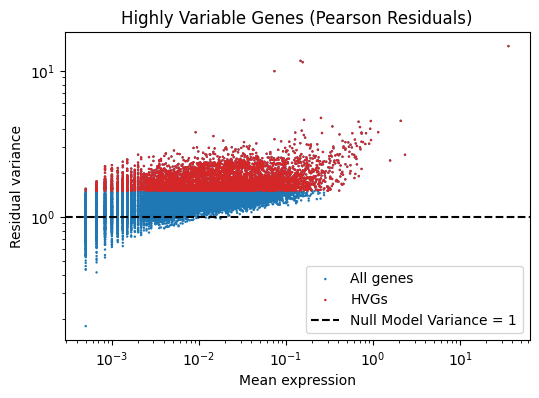

In [ ]:
# Extract mean and residual variances
mean_counts = adata.var["mean_counts"]
residual_variances = adata.var["residual_variances"]
hvgs = adata.var["highly_variable"]

# Scatter plot of residual variance vs. mean expression
plt.figure(figsize=(6, 4))
plt.scatter(mean_counts, residual_variances, s=3, edgecolor="none", label="All genes")
plt.scatter(mean_counts[hvgs], residual_variances[hvgs], c="tab:red", s=3, edgecolor="none", label="HVGs")

# Add reference line (expected variance = 1)
plt.axhline(y=1, color="black", linestyle="--", label="Null Model Variance = 1")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Residual variance")
plt.title("Highly Variable Genes (Pearson Residuals)")
plt.legend()
plt.show()

## 4. Compare HVG Selection: Pearson vs. Seurat

In [ ]:
# !pip install matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45347 sha256=9bd3f8928445fbed17a1c7b5592ba6203e5ce69a03799eb8c5701da55b598157
  Stored in directory: /Users/georgegavriilidis/Library/Caches/pip/wheels/3c/b6/e2/5fadaf4aa63fac5b079d4f633e9d96b29a67ee4fae816806f3
Successfully built matplotlib-venn


In [ ]:
from matplotlib_venn import venn2

# Compute HVGs using Seurat flavor with raw counts
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="raw"  # Specify raw count layer
)
hvg_seurat = set(adata.var_names[adata.var["highly_variable"]])

# # Compute HVGs using Pearson residuals
# sc.experimental.pp.highly_variable_genes(
#     adata,
#     flavor="pearson_residuals",
#     n_top_genes=2000
# )
# hvg_pearson = set(adata.var_names[adata.var["highly_variable"]])

# # Plot Venn diagram
# plt.figure(figsize=(4, 4))
# venn2([hvg_seurat, hvg_pearson], set_labels=("Seurat HVGs", "Pearson Residuals HVGs"))
# plt.title("HVG Selection Methods Comparison")
# plt.show()

### **Highly Variable Gene (HVG) Calculation: Seurat vs Pearson Residuals**

In single-cell RNA-seq analysis, identifying **highly variable genes (HVGs)** is a crucial step. Different methods, such as **Seurat V3 flavor** and **Pearson residuals**, employ distinct strategies for identifying HVGs, which often results in **limited overlap between the two methods**.

---

### **How Seurat and Pearson Residuals Calculate HVGs**

### **1️⃣ Seurat V3 Flavor**
- **Purpose:** Identifies HVGs based on raw count data.
- **Steps:**
  1. Calculates **mean expression** and **dispersion (variance/mean)** for each gene.
  2. Fits a **loess regression** to model the relationship between mean expression and dispersion.
  3. Selects genes with the highest **residual dispersion** (above the fitted curve).
- **Strengths:**
  - Specifically optimized for raw count data.
  - Suitable for identifying highly dispersed genes.
- **Limitations:**
  - Assumes variance follows a specific distribution, which might not hold for all datasets.
  - Requires raw integer count data.

---

### **2️⃣ Pearson Residuals**
- **Purpose:** Identifies HVGs using a variance-stabilized approach.
- **Steps:**
  1. Computes a **null model** of expected counts, assuming no biological variability.
  2. Calculates **Pearson residuals**:
     \[
     \text{Residual} = \frac{\text{Observed} - \text{Expected}}{\sqrt{\text{Expected}}}
     \]
  3. Selects genes with **residual variance > 1** (indicating biological variability).
- **Strengths:**
  - Stabilizes variance across genes.
  - More robust to technical noise and systematic biases.
- **Limitations:**
  - Requires normalized or preprocessed data.

---

### **Why Do Seurat and Pearson Residuals Have Limited Overlap?**

1. **Different Data Requirements:**
   - Seurat requires **raw integer counts**, while Pearson residuals operate on **normalized/preprocessed data**.
   - This difference inherently affects the list of identified HVGs.

2. **Statistical Framework:**
   - Seurat focuses on **dispersion** relative to the mean, selecting genes with the highest residual dispersion.
   - Pearson residuals use a **variance-stabilized null model**, identifying genes with variability beyond expected noise.

3. **Focus of Each Method:**
   - Seurat is **more sensitive to highly expressed genes** with large variance.
   - Pearson residuals are better at highlighting **biologically variable genes**, even among lowly expressed genes.

4. **Biological Context:**
   - Seurat tends to identify genes with **large technical variance** or high dropout, while Pearson residuals prioritize **genes with true biological variability**.

---

### **Key Takeaways**
- **Overlap is Small:** The limited overlap reflects the distinct statistical approaches and data requirements of the methods.
- **Complementary Use:** Combining both methods can provide a more comprehensive set of HVGs for downstream analyses, balancing sensitivity to technical and biological variability.
- **Best Practice:** Choose the method that aligns with the data type (raw or normalized) and the goal of the analysis (e.g., technical variability vs. biological variability).

---

### **Next Steps**
- Use **Seurat** when working with raw count data to identify genes with the largest dispersion.
- Use **Pearson residuals** for normalized data to detect genes with true biological variability.
- Consider combining the two methods to capture both technical and biological variability.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute HVGs using Seurat V3 flavor
# Recompute HVGs using Seurat V3 flavor
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="raw"  # Ensure raw counts are used
)

In [ ]:
print(adata.layers["raw"])  # Ensure raw counts layer exists
print(adata.layers["raw"].dtype)  # Should be integers


<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 1917023 stored elements and shape (5978, 19193)>
  Coords	Values
  (19, 0)	1.0
  (22, 0)	1.0
  (97, 0)	1.0
  (112, 0)	2.0
  (149, 0)	1.0
  (535, 0)	2.0
  (610, 0)	1.0
  (724, 0)	1.0
  (753, 0)	1.0
  (761, 0)	1.0
  (849, 0)	1.0
  (1051, 0)	1.0
  (1275, 0)	1.0
  (1651, 0)	1.0
  (1667, 0)	2.0
  (1686, 0)	1.0
  (1947, 0)	1.0
  (1991, 0)	1.0
  (2065, 0)	1.0
  (2750, 0)	1.0
  (2861, 0)	1.0
  (2916, 0)	1.0
  (3057, 0)	1.0
  (3108, 0)	1.0
  (3110, 0)	1.0
  :	:
  (5975, 19191)	1.0
  (67, 19192)	2.0
  (222, 19192)	1.0
  (615, 19192)	1.0
  (1208, 19192)	2.0
  (1838, 19192)	1.0
  (2095, 19192)	1.0
  (2099, 19192)	1.0
  (2355, 19192)	1.0
  (2440, 19192)	1.0
  (2915, 19192)	1.0
  (2991, 19192)	1.0
  (3235, 19192)	1.0
  (3314, 19192)	1.0
  (3386, 19192)	1.0
  (4113, 19192)	1.0
  (4420, 19192)	1.0
  (4508, 19192)	1.0
  (4646, 19192)	2.0
  (4760, 19192)	1.0
  (4988, 19192)	1.0
  (5008, 19192)	1.0
  (5084, 19192)	1.0
  (5275, 19192)	1.0
  

In [ ]:
print(adata.var.columns)

Index(['gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts',
       'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances',
       'residual_variances', 'highly_variable_rank', 'highly_variable',
       'mean_expression', 'mean_raw', 'var_raw', 'mean_sqrt', 'var_sqrt',
       'mean_pearson', 'var_pearson', 'variances_norm'],
      dtype='object')


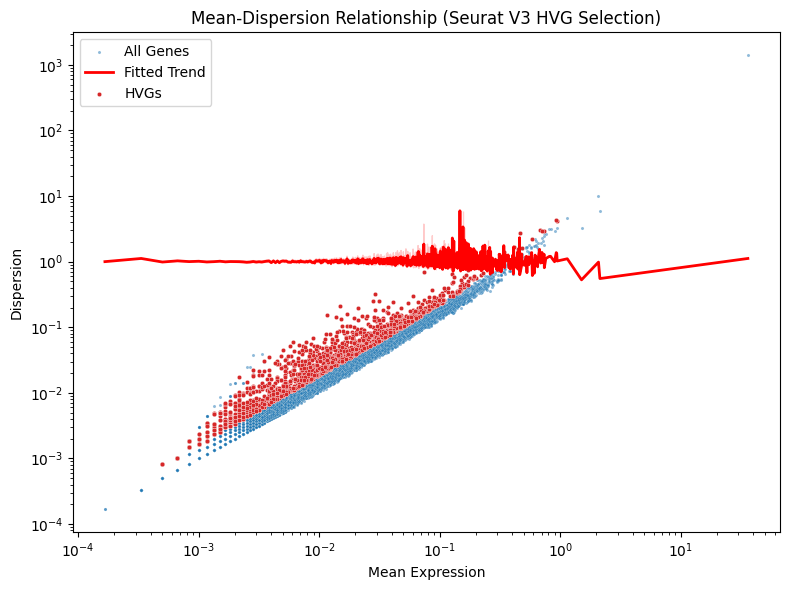

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant data
mean = adata.var["means"]  # Mean expression
dispersion = adata.var["variances"]  # Observed dispersion
dispersion_fit = adata.var["variances_norm"]  # Fitted dispersion trend
hvg_mask = adata.var["highly_variable"]  # Mask for HVGs

# Plot mean-dispersion relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=mean, y=dispersion, s=5, alpha=0.5, label="All Genes")
sns.lineplot(x=mean, y=dispersion_fit, color="red", label="Fitted Trend", lw=2)
sns.scatterplot(x=mean[hvg_mask], y=dispersion[hvg_mask], color="tab:red", s=10, label="HVGs")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean Expression")
plt.ylabel("Dispersion")
plt.title("Mean-Dispersion Relationship (Seurat V3 HVG Selection)")
plt.legend()
plt.tight_layout()
plt.show()


### **Mean-Dispersion Relationship: Seurat V3 HVG Selection**

The plot visualizes the relationship between **mean expression** and **dispersion** (variance normalized by mean) for all genes in the dataset. It illustrates how Seurat V3 selects **highly variable genes (HVGs)** based on their dispersion relative to a fitted trend.

---

### **Key Elements of the Plot**

1. **Blue Dots (All Genes):**
   - Represent all genes in the dataset.
   - Show the observed dispersion values across a range of mean expression levels.
   - Dispersion decreases as mean expression increases due to technical effects and mean-variance dependency.

2. **Red Line (Fitted Trend):**
   - Represents the **expected dispersion** for genes at each mean expression level.
   - The line is computed using a **LOESS regression**, capturing the mean-variance trend.
   - This trend separates genes with expected variability from those with excess variability.

3. **Red Dots (HVGs):**
   - Highlight genes classified as **highly variable genes (HVGs)**.
   - HVGs are outliers with **dispersion values significantly above the fitted trend**.
   - These genes likely exhibit true biological variability and are candidates for further analysis.

---

### **What Does This Plot Explain?**

- **HVG Selection Process:**
  - Seurat V3 identifies genes with higher-than-expected variability relative to the fitted trend.
  - The selection accounts for mean expression, ensuring fair comparisons between genes with different expression levels.

- **Biological Insight:**
  - HVGs are more likely to represent biologically relevant variability, such as differences in gene expression across cell types or conditions.

---

### **Interpretation and Use Cases**

1. **Validation of HVG Selection:**
   - Ensure that the fitted trend (red line) accurately models the mean-variance dependency.
   - Confirm that selected HVGs (red dots) are appropriate outliers.

2. **Downstream Analyses:**
   - Use the identified HVGs for tasks like:
     - **Clustering**: HVGs drive separation of cell types.
     - **Differential Expression Analysis**: Focus on biologically relevant genes.
     - **Pathway Enrichment**: Analyze the pathways enriched in HVGs.

---

### **Suggestions for Refinement**

- **Add Gene Annotations:**
  - Highlight specific HVGs of interest (e.g., known markers or genes with biological significance).

- **Color HVGs by Metadata:**
  - If you have metadata (e.g., cell type or condition labels), color-code HVGs to visualize biological trends.

- **Compare with Other HVG Methods:**
  - Generate similar plots for Pearson residuals or other methods to understand differences in HVG selection.

---

This plot provides a clear visualization of how Seurat V3 identifies biologically variable genes, making it a key step in single-cell RNA-seq preprocessing and analysis.


# Cell type annotation

In [106]:
!pip install celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 57.7 MB/s eta 0:00:00


In [107]:
import celltypist
celltypist.models.download_models("Developing_Human_Brain.pkl")

In [120]:
import celltypist
from celltypist.models import Model
from celltypist import annotate



# Ensure the features (genes) match the model
adata.var_names = adata.var_names.str.upper()  # Convert gene names to uppercase if needed

In [108]:
from celltypist.models import Model

# Load the model
model = Model.load("Developing_Human_Brain.pkl")

# Check model details
print(model)

CellTypist model with 129 cell types and 1000 features
    date: 2022-10-29 21:02:53.713593
    details: cell types from the first-trimester developing human brain
    source: https://doi.org/10.1126/science.adf1226
    version: v1
    cell types: Brain erythrocytes, Brain fibroblasts, ..., Ventral midbrain radial glia
    features: VWA1, HES5, ..., BGN


In [122]:
import scanpy as sc

# Check if 'raw' layer exists and use it
if "raw" in adata.layers:
    adata.X = adata.layers["raw"].copy()
else:
    print("No raw count layer found! Check your original dataset.")

# Normalize counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log1p transformation
sc.pp.log1p(adata)

# Verify min/max values to check if data is in expected range
print(f"Min value: {adata.X.min()}, Max value: {adata.X.max()}")

Min value: 0.0, Max value: 4.820268154144287


In [123]:
# Annotate cell types using the CellTypist model
predictions = annotate(adata, model="Developing_Human_Brain.pkl", mode="best match")

# Add predictions to the AnnData object
adata.obs["celltypist_pred"] = predictions.predicted_labels

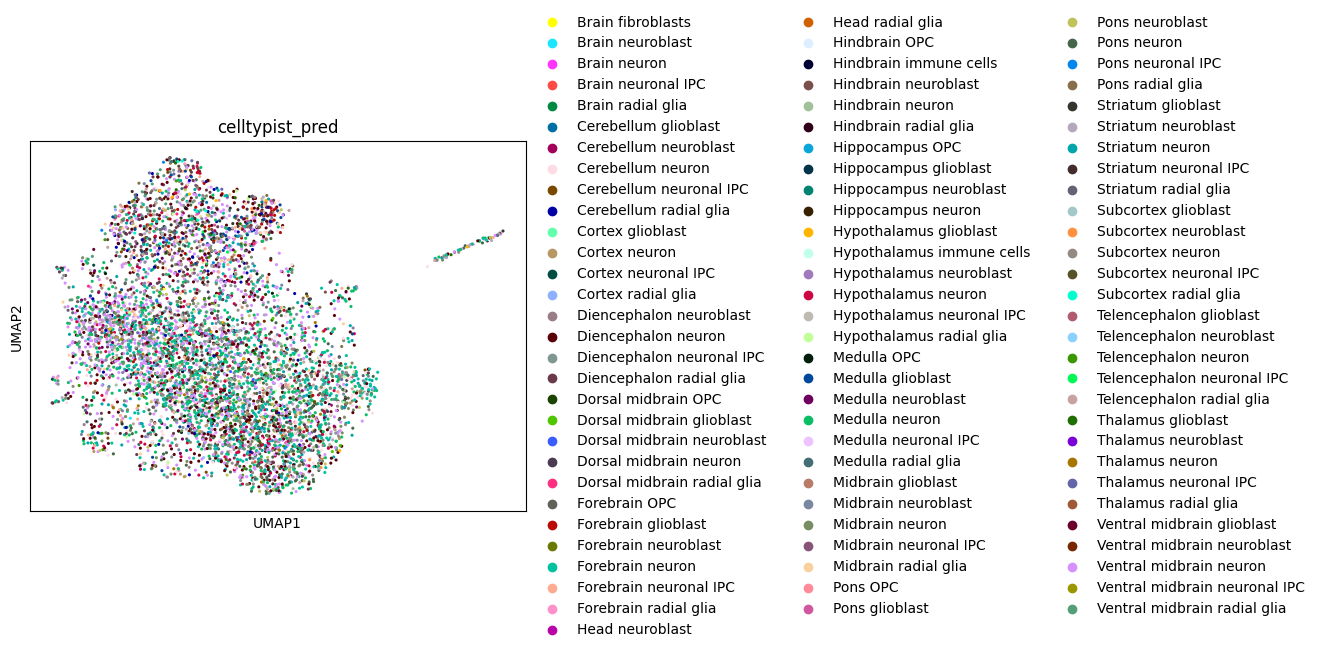

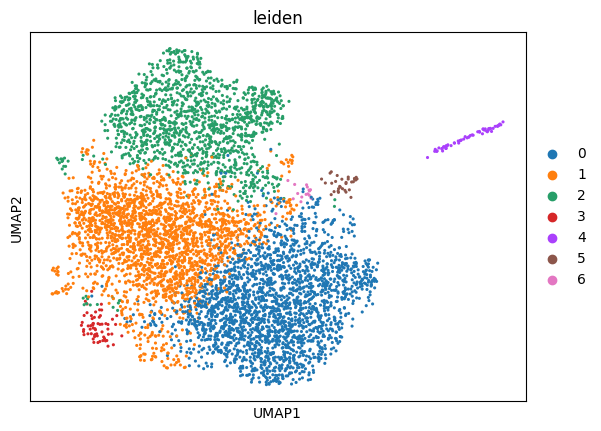

In [124]:
import scanpy as sc

# UMAP plot with CellTypist predictions
sc.pl.umap(adata, color=["celltypist_pred"])
sc.pl.umap(adata, color=["leiden"])

In [125]:
from celltypist import annotate

# Define the human brain models
brain_models = [
    "Developing_Human_Brain.pkl",
    "Developing_Human_Hippocampus.pkl",
    "Human_AdultAged_Hippocampus.pkl",
    "Human_Longitudinal_Hippocampus.pkl",
    "Adult_Human_PrefrontalCortex.pkl",
    "Adult_Human_MTG.pkl"
]

# Dictionary to store predictions
model_predictions = {}

# Loop through each brain-related model
for model_name in brain_models:
    print(f"🔍 Running CellTypist with model: {model_name}")

    # Annotate cells with the current model
    predictions = annotate(adata, model=model_name, mode="best match")

    # Store predictions in a new column
    model_col_name = f"celltypist_{model_name.replace('.pkl', '')}"  # Clean names
    adata.obs[model_col_name] = predictions.predicted_labels

    # Store results
    model_predictions[model_name] = predictions.predicted_labels

print("✅ Annotation completed for all human brain models!")

🔍 Running CellTypist with model: Developing_Human_Brain.pkl
🔍 Running CellTypist with model: Developing_Human_Hippocampus.pkl
🔍 Running CellTypist with model: Human_AdultAged_Hippocampus.pkl
🔍 Running CellTypist with model: Human_Longitudinal_Hippocampus.pkl
🔍 Running CellTypist with model: Adult_Human_PrefrontalCortex.pkl
🔍 Running CellTypist with model: Adult_Human_MTG.pkl
✅ Annotation completed for all human brain models!


In [126]:
# Create a dataframe with all model predictions
df = adata.obs[["leiden"] + [f"celltypist_{m.replace('.pkl', '')}" for m in brain_models]]

# Group by leiden clusters and check majority vote per model
summary = df.groupby("leiden").agg(lambda x: x.value_counts().idxmax())
summary

celltypist_Developing_Human_Brain  \
leiden                                     
0                       Forebrain neuron   
1                Ventral midbrain neuron   
2                Ventral midbrain neuron   
3                    Diencephalon neuron   
4                Ventral midbrain neuron   
5                         Medulla neuron   
6                        Striatum neuron   

       celltypist_Developing_Human_Hippocampus  \
leiden                                           
0                                  Endothelial   
1                                  Endothelial   
2                                  Endothelial   
3                                  Endothelial   
4                                  Endothelial   
5                                  Endothelial   
6                                  Endothelial   

       celltypist_Human_AdultAged_Hippocampus  \
leiden                                          
0                                 CA1_neurons   
1                                 CA1_neurons   
2                                  Astrocytes   
3                                 CA1_neurons   
4                                 CA1_neurons   
5                                 CA1_neurons   
6                                 CA1_neurons   

       celltypist_Human_Longitudinal_Hippocampus  \
leiden                                             
0                                          Olig3   
1                                          Olig3   
2                                          Olig3   
3                                          Olig3   
4                                          Olig3   
5                                          Olig3   
6                                          Olig3   

       celltypist_Adult_Human_PrefrontalCortex celltypist_Adult_Human_MTG  
leiden                                                                     
0                            Endo CLDN5 SLC7A5                Micro-PVM_2  
1                            Endo CLDN5 SLC7A5                Micro-PVM_2  
2                            Endo CLDN5 SLC7A5                Micro-PVM_2  
3                            Endo CLDN5 SLC7A5                Micro-PVM_2  
4                            Endo CLDN5 SLC7A5                Micro-PVM_2  
5                            Endo CLDN5 SLC7A5                Micro-PVM_2  
6                            Endo CLDN5 SLC7A5                Micro-PVM_2

<Figure size 1200x600 with 0 Axes>

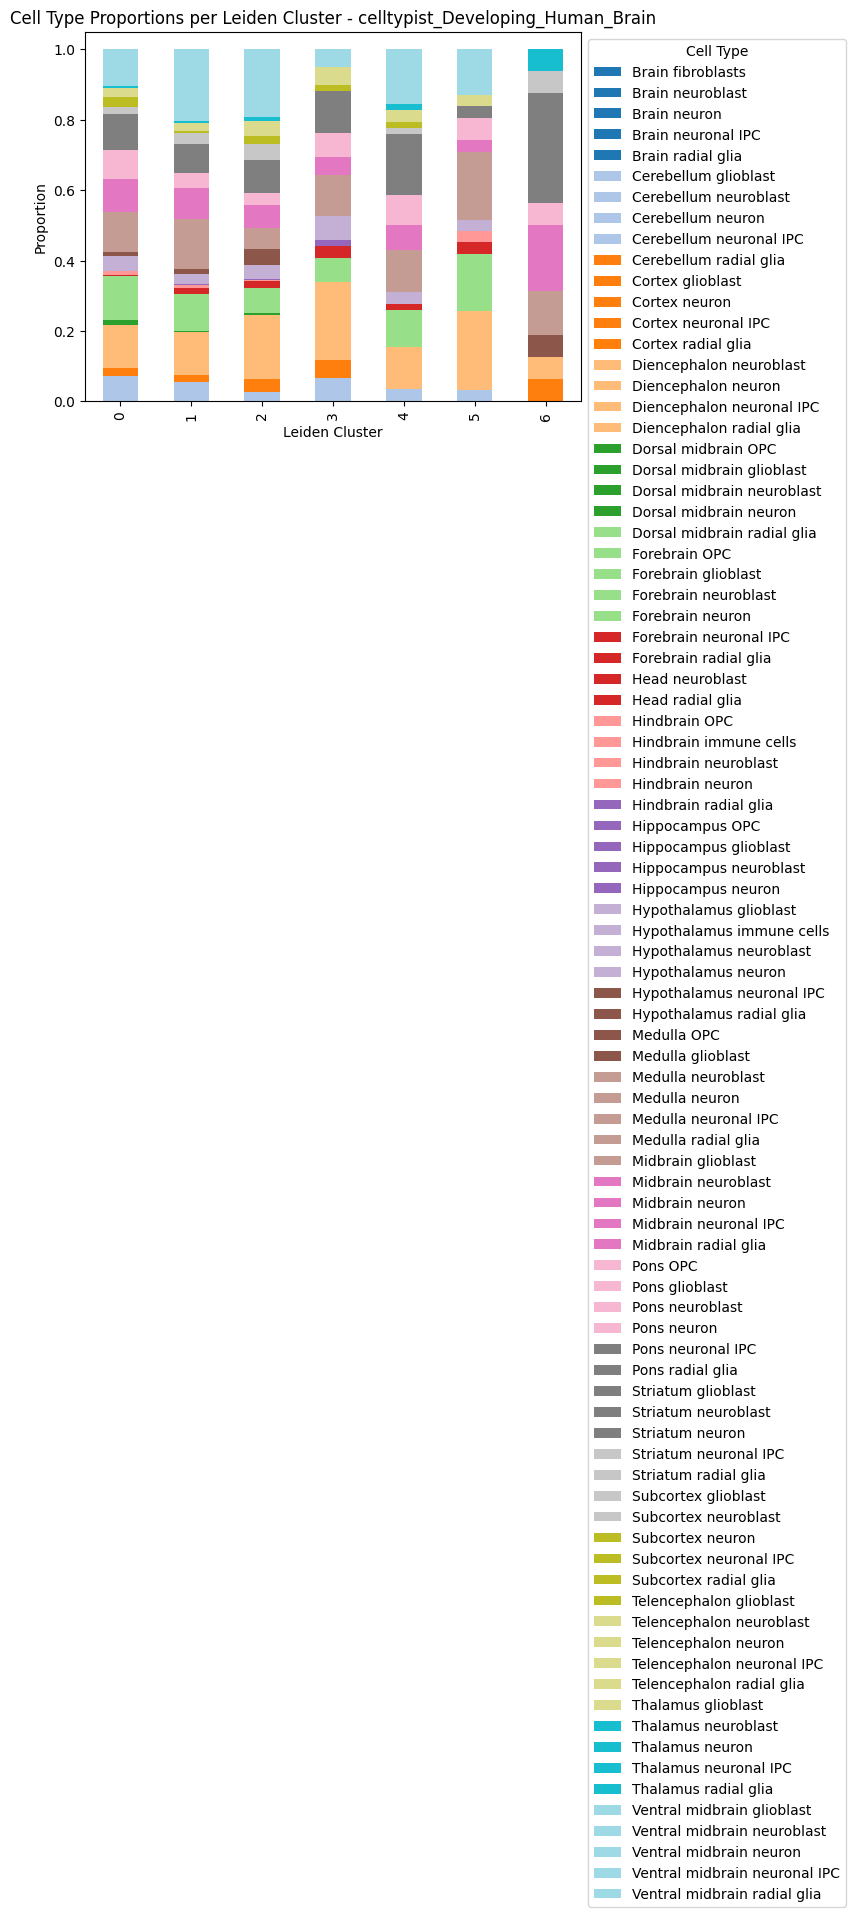

<Figure size 1200x600 with 0 Axes>

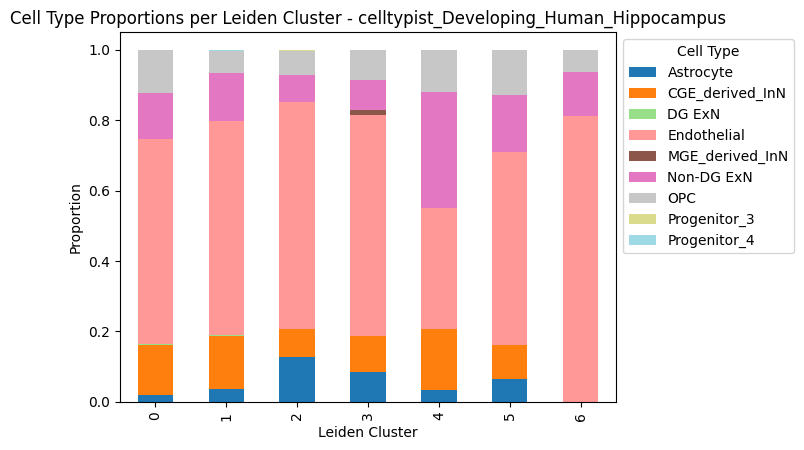

<Figure size 1200x600 with 0 Axes>

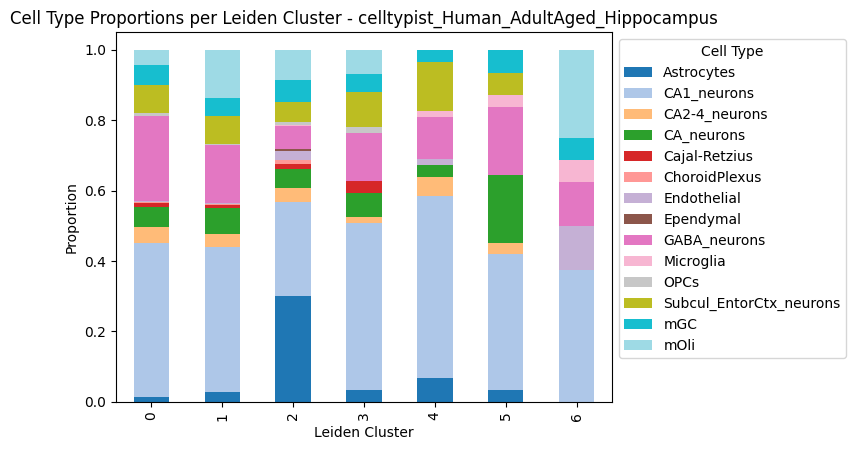

<Figure size 1200x600 with 0 Axes>

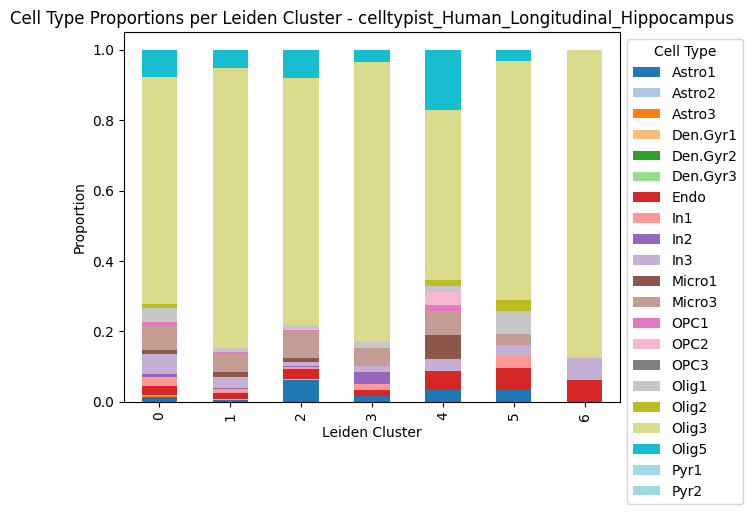

<Figure size 1200x600 with 0 Axes>

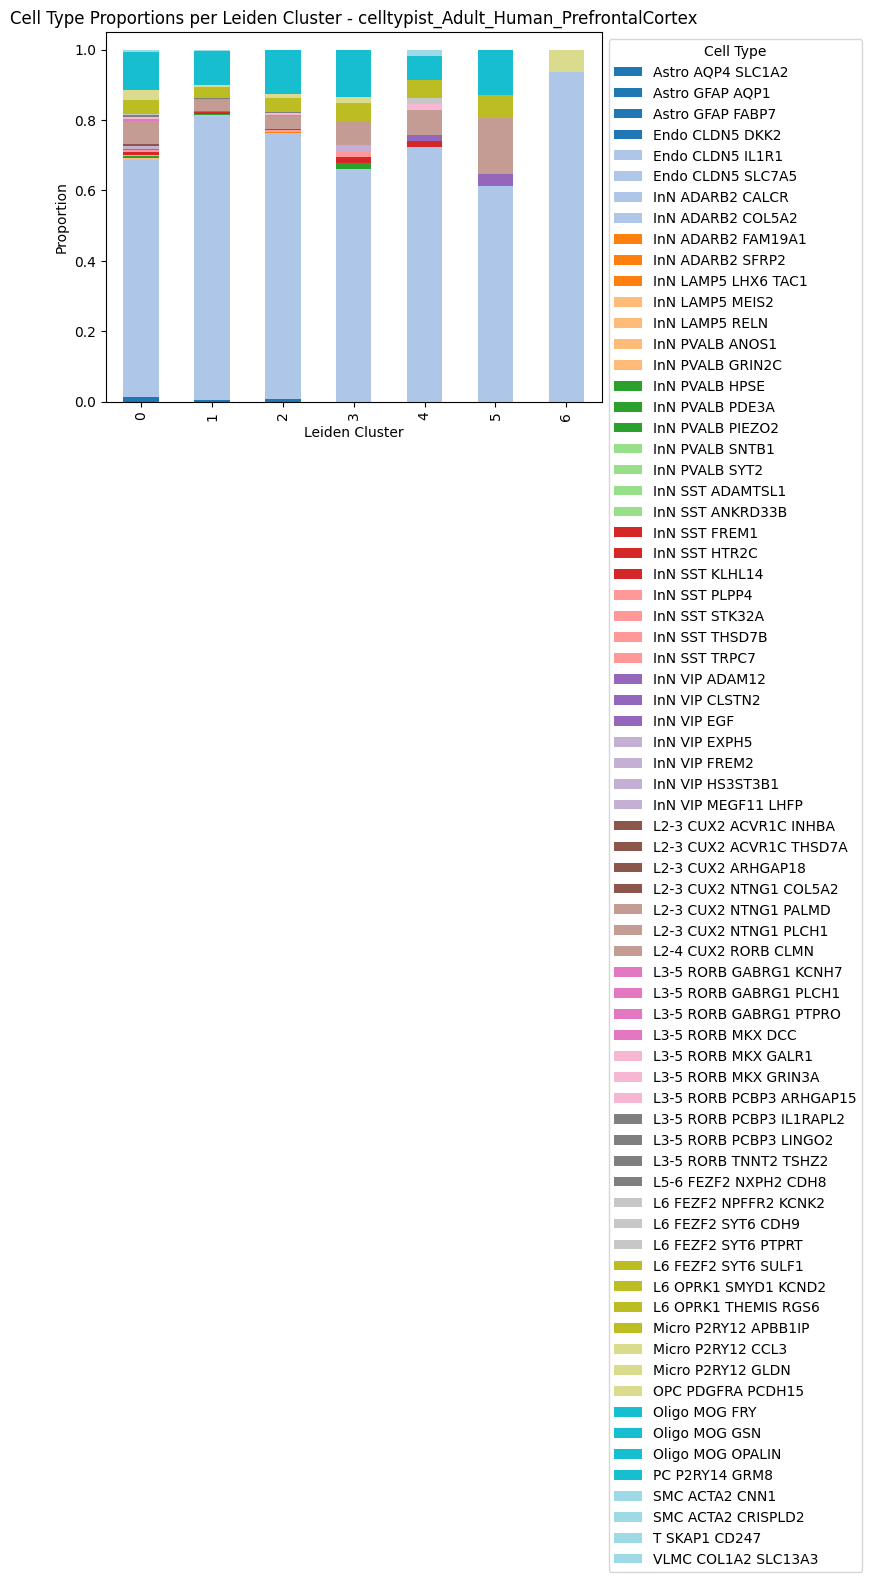

<Figure size 1200x600 with 0 Axes>

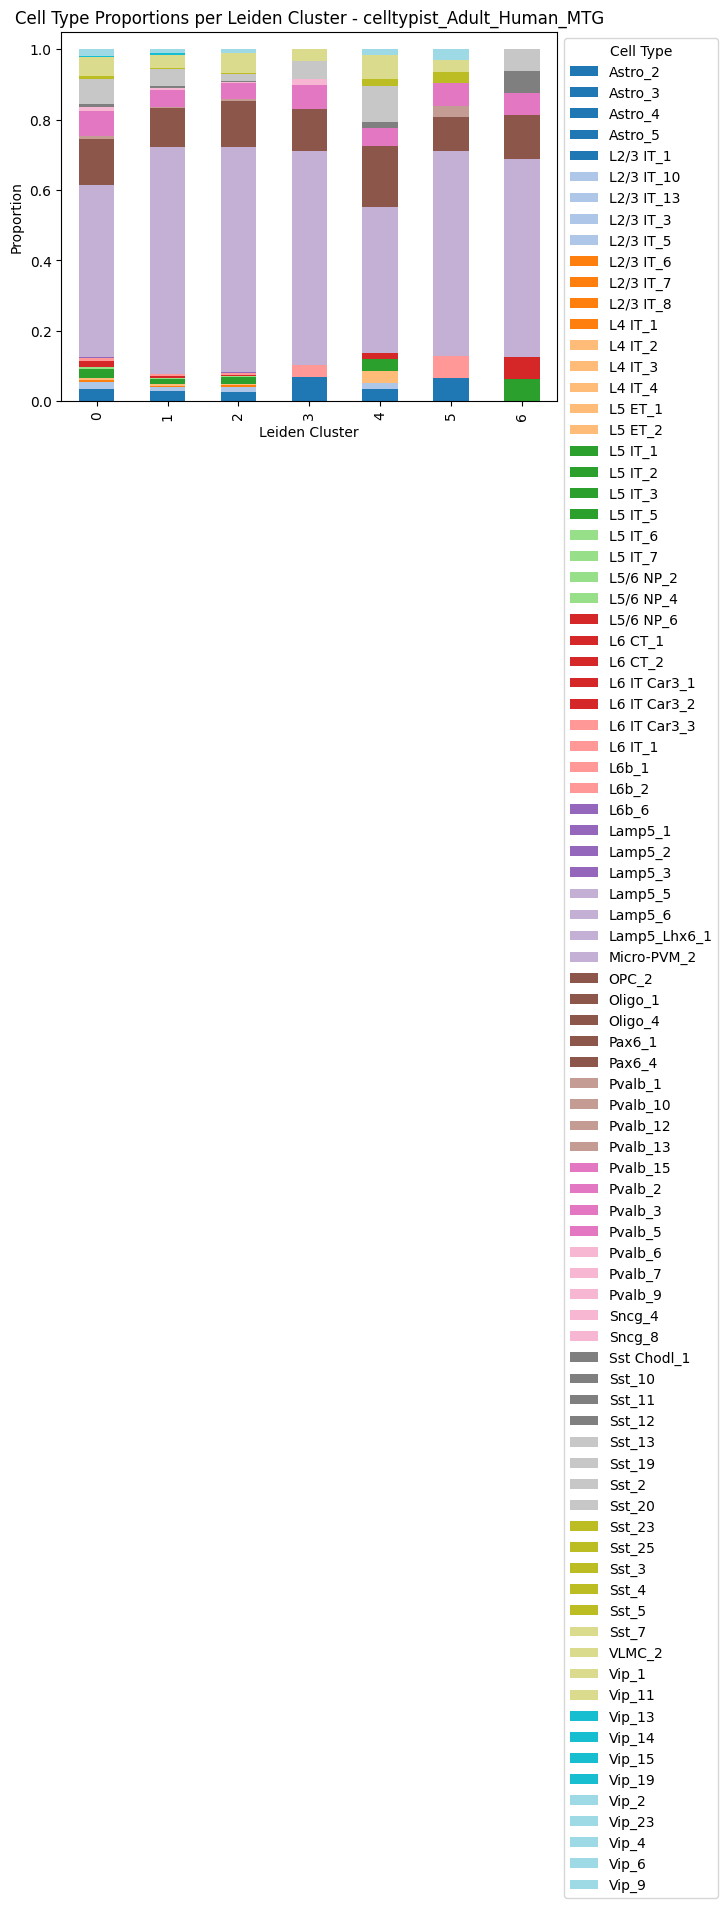

In [127]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the human brain models
brain_models = [
    "Developing_Human_Brain.pkl",
    "Developing_Human_Hippocampus.pkl",
    "Human_AdultAged_Hippocampus.pkl",
    "Human_Longitudinal_Hippocampus.pkl",
    "Adult_Human_PrefrontalCortex.pkl",
    "Adult_Human_MTG.pkl"
]

# Loop through each brain-related model and create separate barplots
for model_name in brain_models:
    model_col_name = f"celltypist_{model_name.replace('.pkl', '')}"

    # Create a proportion table
    celltype_counts = adata.obs.groupby(["leiden", model_col_name]).size().unstack(fill_value=0)
    celltype_proportions = celltype_counts.div(celltype_counts.sum(axis=1), axis=0)

    # Plot as a stacked barplot
    plt.figure(figsize=(12, 6))
    celltype_proportions.plot(kind="bar", stacked=True, colormap="tab20")
    plt.ylabel("Proportion")
    plt.xlabel("Leiden Cluster")
    plt.title(f"Cell Type Proportions per Leiden Cluster - {model_col_name}")
    plt.legend(title="Cell Type", bbox_to_anchor=(1, 1), loc="upper left")

    # Show the plot for the current model
    plt.show()

# Pathway enrichment

In this notebook we showcase how to use `decoupler` for functional enrichment.

In [128]:
!pip install decoupler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.26.4 requires numpy<2,>=1.17.0, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.17 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you 

In [129]:
import decoupler as dc

The Molecular Signatures Database (MSigDB) is a resource containing a collection of gene sets annotated to different biological processes.


In [130]:
msigdb = dc.get_resource('MSigDB')
msigdb

genesymbol             collection  \
                                            
0             A1BG            immunesigdb   
1             A1BG      tf_targets_legacy   
2             A1BG             positional   
3             A1BG   cell_type_signatures   
4             A1BG  go_cellular_component   
...            ...                    ...   
5522261       ZZZ3  go_biological_process   
5522262       ZZZ3  go_biological_process   
5522263       ZZZ3        tf_targets_gtrf   
5522264       ZZZ3            immunesigdb   
5522265       ZZZ3            immunesigdb   

                                                   geneset  
                                                            
0        GSE25088_CTRL_VS_IL4_AND_ROSIGLITAZONE_STIM_MA...  
1                                          TGTTTGY_HNF3_Q6  
2                                                 chr19q13  
3           GAO_LARGE_INTESTINE_ADULT_CI_MESENCHYMAL_CELLS  
4                    GOCC_EXTERNAL_ENCAPSULATING_STRUCTURE  
...                                                    ...  
5522261                     GOBP_MACROMOLECULE_DEACYLATION  
5522262                                    GOBP_CELL_CYCLE  
5522263                                ZNF507_TARGET_GENES  
5522264      GSE3982_NEUTROPHIL_VS_EFF_MEMORY_CD4_TCELL_DN  
5522265          GSE18893_CTRL_VS_TNF_TREATED_TCONV_24H_UP  

[5522266 rows x 3 columns]

In [131]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

genesymbol collection                           geneset
                                                               
455            A2M   hallmark              HALLMARK_COAGULATION
557            A2M   hallmark  HALLMARK_IL6_JAK_STAT3_SIGNALING
917           AAAS   hallmark               HALLMARK_DNA_REPAIR
1471         AADAT   hallmark    HALLMARK_FATTY_ACID_METABOLISM
2932         AARS1   hallmark      HALLMARK_ALLOGRAFT_REJECTION
...            ...        ...                               ...
5516433       ZPBP   hallmark          HALLMARK_SPERMATOGENESIS
5520316       ZW10   hallmark              HALLMARK_E2F_TARGETS
5520404       ZW10   hallmark        HALLMARK_PROTEIN_SECRETION
5520778      ZWINT   hallmark               HALLMARK_DNA_REPAIR
5521536        ZYX   hallmark          HALLMARK_APICAL_JUNCTION

[11289 rows x 3 columns]

To infer functional enrichment scores we will run the Over Representation Analysis `ora` method. As input data it accepts an expression matrix `decoupler.run_ora` or the results of differential expression analysis `decoupler.run_ora_df`. For the former, by default the top 5% of expressed genes by sample are selected as the set of interest `S`, and for the latter a user-defined significance filtering can be used. Once we have S, it builds a contingency table using set operations for each set stored in the gene set resource being used `net`. Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets. The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

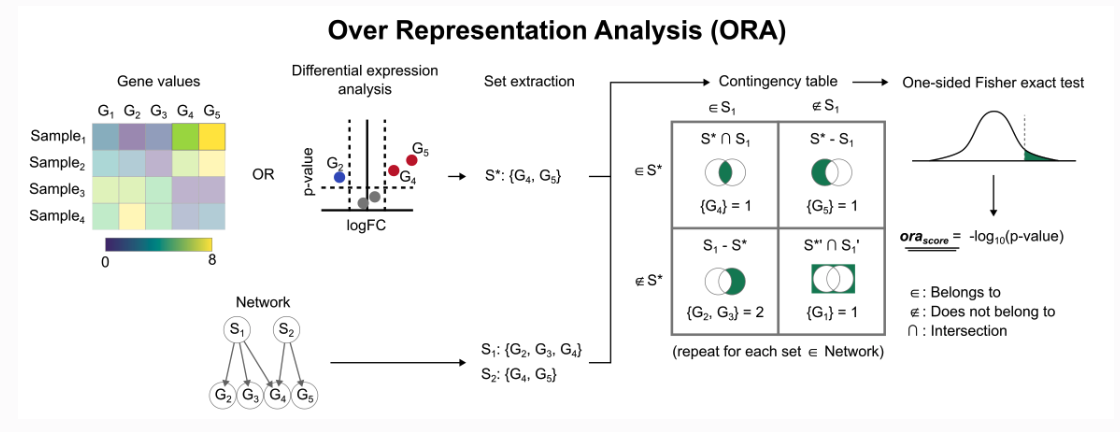

In [133]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True, use_raw=False
)

Running ora on mat with 5978 samples and 19193 targets for 50 sources.


  0%|          | 0/5978 [00:00<?, ?it/s]

In [134]:
adata.obsm['ora_estimate']

source                       HALLMARK_ADIPOGENESIS  \
AACACACAGAACGCTAGTACTATCGCC               1.318601   
AACACACAGAACGCTAGTCCATCCTAA               1.318601   
AACACACAGAACGTCCAACCATCCTAA               0.454767   
AACACACAGAACGTCCAACTCTGCTTA               0.827158   
AACACACAGAACGTCCAACTGCGTAGT               0.827158   
...                                            ...   
TGTGGACACTGGTCAGTTACTGAAGCA               0.625794   
TGTGGACACTGTCGGTGTGACTAACGG               0.314187   
TGTGGACACTTCCAATCGATGAGTCCT               0.454767   
TGTGGACACTTCGAGGATTCTCCAGAT               1.058343   
TGTGGACACTTGCCGTCAACGTCCATA               0.827158   

source                       HALLMARK_ALLOGRAFT_REJECTION  \
AACACACAGAACGCTAGTACTATCGCC                      0.230383   
AACACACAGAACGCTAGTCCATCCTAA                      0.230383   
AACACACAGAACGTCCAACCATCCTAA                      0.118467   
AACACACAGAACGTCCAACTCTGCTTA                      0.118467   
AACACACAGAACGTCCAACTGCGTAGT                      0.049209   
...                                                   ...   
TGTGGACACTGGTCAGTTACTGAAGCA                      0.230383   
TGTGGACACTGTCGGTGTGACTAACGG                      0.118467   
TGTGGACACTTCCAATCGATGAGTCCT                      0.118467   
TGTGGACACTTCGAGGATTCTCCAGAT                      0.118467   
TGTGGACACTTGCCGTCAACGTCCATA                      0.118467   

source                       HALLMARK_ANDROGEN_RESPONSE  \
AACACACAGAACGCTAGTACTATCGCC                    0.832750   
AACACACAGAACGCTAGTCCATCCTAA                    0.832750   
AACACACAGAACGTCCAACCATCCTAA                    0.832750   
AACACACAGAACGTCCAACTCTGCTTA                    0.565823   
AACACACAGAACGTCCAACTGCGTAGT                    0.565823   
...                                                 ...   
TGTGGACACTGGTCAGTTACTGAAGCA                    0.832750   
TGTGGACACTGTCGGTGTGACTAACGG                    0.565823   
TGTGGACACTTCCAATCGATGAGTCCT                    1.516082   
TGTGGACACTTCGAGGATTCTCCAGAT                    1.150435   
TGTGGACACTTGCCGTCAACGTCCATA                    1.150435   

source                       HALLMARK_ANGIOGENESIS  HALLMARK_APICAL_JUNCTION  \
AACACACAGAACGCTAGTACTATCGCC               0.141524                  0.641151   
AACACACAGAACGCTAGTCCATCCTAA               0.447517                  0.641151   
AACACACAGAACGTCCAACCATCCTAA               0.141524                  0.458572   
AACACACAGAACGTCCAACTCTGCTTA               0.447517                  0.641151   
AACACACAGAACGTCCAACTGCGTAGT               0.447517                  1.106023   
...                                            ...                       ...   
TGTGGACACTGGTCAGTTACTGAAGCA               0.141524                  0.857217   
TGTGGACACTGTCGGTGTGACTAACGG               0.141524                  1.697774   
TGTGGACACTTCCAATCGATGAGTCCT               0.141524                  0.641151   
TGTGGACACTTCGAGGATTCTCCAGAT               0.141524                  1.106023   
TGTGGACACTTGCCGTCAACGTCCATA               0.141524                  1.106023   

source                       HALLMARK_APICAL_SURFACE  HALLMARK_APOPTOSIS  \
AACACACAGAACGCTAGTACTATCGCC                 0.628450            0.133641   
AACACACAGAACGCTAGTCCATCCTAA                 1.069555            0.387757   
AACACACAGAACGTCCAACCATCCTAA                 0.628450            0.063292   
AACACACAGAACGTCCAACTCTGCTTA                 0.628450            0.240766   
AACACACAGAACGTCCAACTGCGTAGT                 0.628450            0.240766   
...                                              ...                 ...   
TGTGGACACTGGTCAGTTACTGAAGCA                 1.069555            0.240766   
TGTGGACACTGTCGGTGTGACTAACGG                 1.069555            0.387757   
TGTGGACACTTCCAATCGATGAGTCCT                 1.069555            0.240766   
TGTGGACACTTCGAGGATTCTCCAGAT                 1.069555            0.240766   
TGTGGACACTTGCCGTCAACGTCCATA                 0.628450            0.803764   

source                       HALLMA

In [135]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 5978 × 50
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'leiden', 'celltypist_pred', 'celltypist_Developing_Human_Brain', 'celltypist_Developing_Human_Hippocampus', 'celltypist_Human_AdultAged_Hippocampus', 'celltypist_Human_Longitudinal_Hippocampus', 'celltypist_Adult_Human_PrefrontalCortex', 'celltypist_Adult_Human_MTG'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'pearson_residuals_normalization', 'celltypist_pred_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

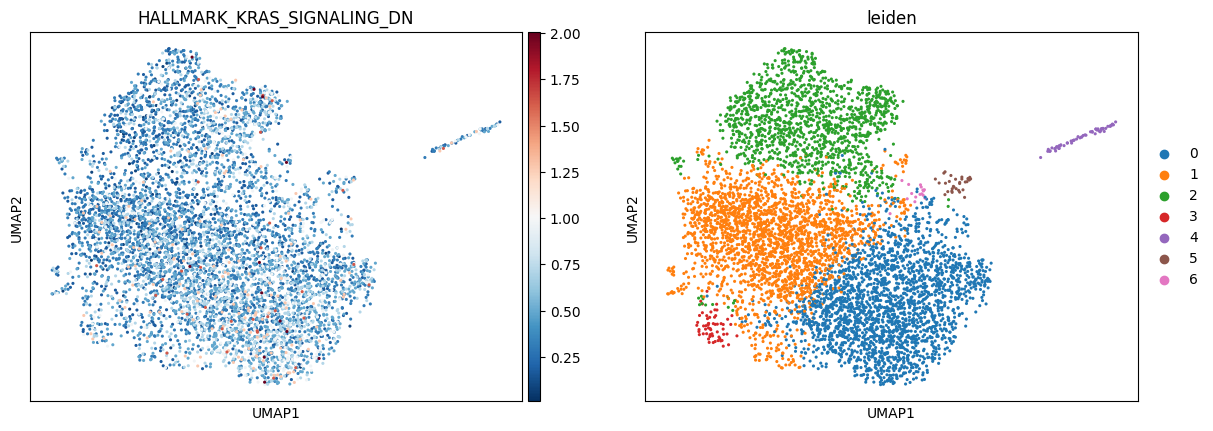

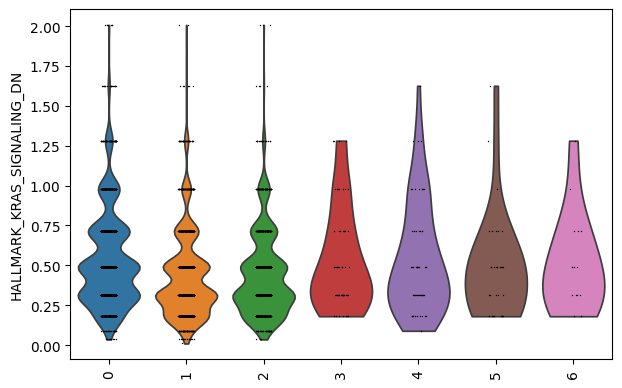

In [143]:
sc.pl.umap(acts, color=["HALLMARK_KRAS_SIGNALING_DN", 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=["HALLMARK_KRAS_SIGNALING_DN"], groupby='leiden', rotation=90)

Let’s identify which are the top gene sets per cell type. We can do it by using the function dc.rank_sources_groups, which identifies marker gene sets using the same statistical tests available in scanpy’s scanpy.tl.rank_genes_groups.

In [138]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

group reference                                     names  statistic  \
0       0      rest                HALLMARK_KRAS_SIGNALING_DN  11.448318   
1       0      rest                   HALLMARK_UV_RESPONSE_DN   5.163391   
2       0      rest          HALLMARK_ESTROGEN_RESPONSE_EARLY   2.461462   
3       0      rest                   HALLMARK_APICAL_SURFACE   1.582147   
4       0      rest                  HALLMARK_SPERMATOGENESIS   1.553651   
..    ...       ...                                       ...        ...   
345     6      rest  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  -1.232576   
346     6      rest                  HALLMARK_HEME_METABOLISM  -1.428238   
347     6      rest       HALLMARK_WNT_BETA_CATENIN_SIGNALING  -1.463959   
348     6      rest                   HALLMARK_UV_RESPONSE_UP  -1.476455   
349     6      rest          HALLMARK_TNFA_SIGNALING_VIA_NFKB  -1.509730   

     meanchange         pvals     pvals_adj  
0      0.097252  6.272534e-30  3.920334e-29  
1      0.097133  2.529578e-07  4.517104e-07  
2      0.012810  1.387439e-02  1.734298e-02  
3      0.017231  1.136863e-01  1.386418e-01  
4      0.010002  1.203387e-01  1.432604e-01  
..          ...           ...           ...  
345   -0.101117  2.306614e-01  9.953851e-01  
346   -0.085639  1.687142e-01  9.953851e-01  
347   -0.137327  1.572751e-01  9.953851e-01  
348   -0.095680  1.532856e-01  9.953851e-01  
349   -0.054515  1.473737e-01  9.953851e-01  

[350 rows x 7 columns]

In [139]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'0': ['HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_UV_RESPONSE_DN',
  'HALLMARK_ESTROGEN_RESPONSE_EARLY'],
 '1': ['HALLMARK_OXIDATIVE_PHOSPHORYLATION',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_UV_RESPONSE_UP'],
 '2': ['HALLMARK_TNFA_SIGNALING_VIA_NFKB',
  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
  'HALLMARK_COAGULATION'],
 '3': ['HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_KRAS_SIGNALING_UP',
  'HALLMARK_MYOGENESIS'],
 '4': ['HALLMARK_COAGULATION',
  'HALLMARK_IL2_STAT5_SIGNALING',
  'HALLMARK_KRAS_SIGNALING_DN'],
 '5': ['HALLMARK_SPERMATOGENESIS',
  'HALLMARK_WNT_BETA_CATENIN_SIGNALING',
  'HALLMARK_IL6_JAK_STAT3_SIGNALING'],
 '6': ['HALLMARK_XENOBIOTIC_METABOLISM',
  'HALLMARK_TGF_BETA_SIGNALING',
  'HALLMARK_FATTY_ACID_METABOLISM']}

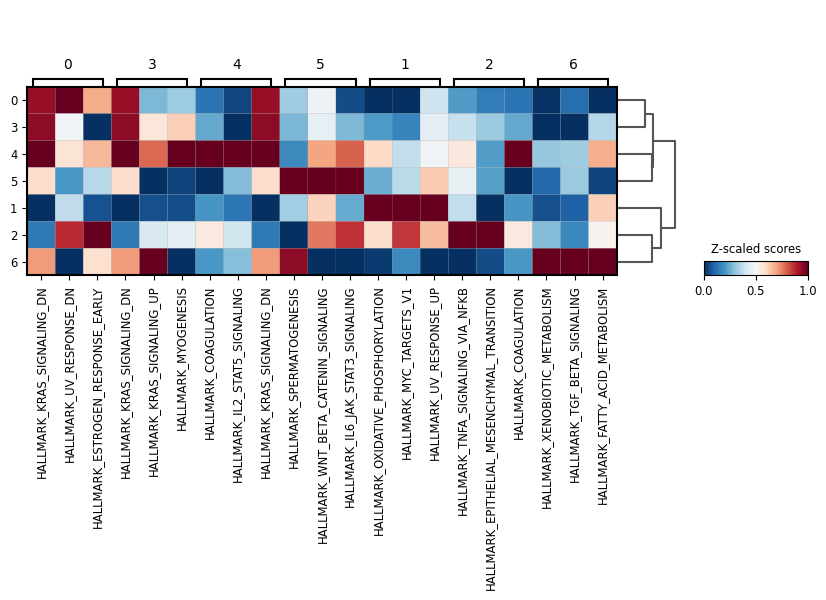

In [141]:
sc.pl.matrixplot(acts, source_markers, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')